In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/OFTALMOLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=342.7, y1=102.2
Page 1, Q1, A: Yellow pixels: 2568
Page 1, Q1, A: Total non-white pixels: 3581
Page 1, Q1, A: Yellow percentage: 71.7%


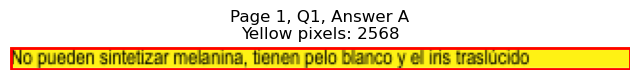

Page 1, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=335.6, y1=114.8
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 1264
Page 1, Q1, B: Yellow percentage: 0.0%


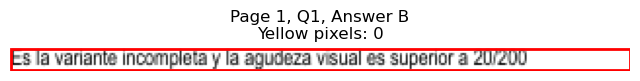

Page 1, Q1 - C: Detected box: x0=68.8, y0=116.4, x1=340.7, y1=127.4
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 1342
Page 1, Q1, C: Yellow percentage: 0.0%


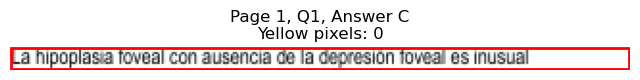

Page 1, Q1 - D: Detected box: x0=68.8, y0=129.0, x1=416.3, y1=140.0
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 1672
Page 1, Q1, D: Yellow percentage: 0.0%


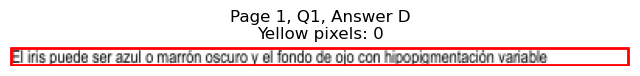


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=217.4, x1=162.6, y1=228.4
Page 1, Q2, A: Yellow pixels: 145
Page 1, Q2, A: Total non-white pixels: 619
Page 1, Q2, A: Yellow percentage: 23.4%


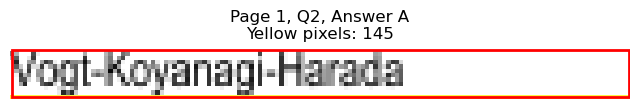

Page 1, Q2 - B: Detected box: x0=68.3, y0=230.0, x1=145.6, y1=241.0
Page 1, Q2, B: Yellow pixels: 1225
Page 1, Q2, B: Total non-white pixels: 1538
Page 1, Q2, B: Yellow percentage: 79.6%


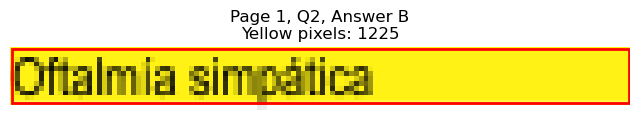

Page 1, Q2 - C: Detected box: x0=327.5, y0=217.4, x1=456.4, y1=228.4
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 654
Page 1, Q2, C: Yellow percentage: 0.0%


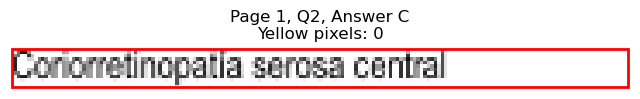

Page 1, Q2 - D: Detected box: x0=327.5, y0=230.0, x1=426.8, y1=241.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 523
Page 1, Q2, D: Yellow percentage: 0.0%


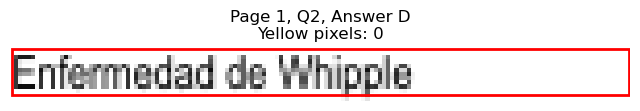


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=146.2, y1=278.8
Page 1, Q3, A: Yellow pixels: 1249
Page 1, Q3, A: Total non-white pixels: 1548
Page 1, Q3, A: Yellow percentage: 80.7%


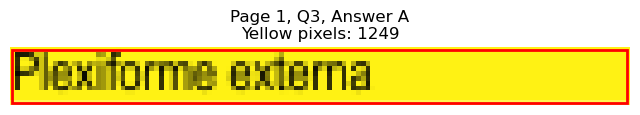

Page 1, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=155.0, y1=291.6
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 494
Page 1, Q3, B: Yellow percentage: 0.0%


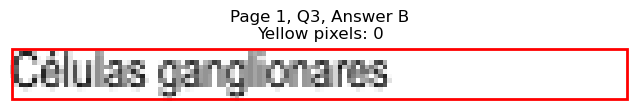

Page 1, Q3 - C: Detected box: x0=327.5, y0=267.8, x1=409.2, y1=278.8
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 435
Page 1, Q3, C: Yellow percentage: 0.0%


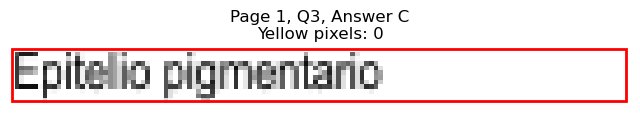

Page 1, Q3 - D: Detected box: x0=327.5, y0=280.5, x1=393.7, y1=291.6
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 334
Page 1, Q3, D: Yellow percentage: 0.0%


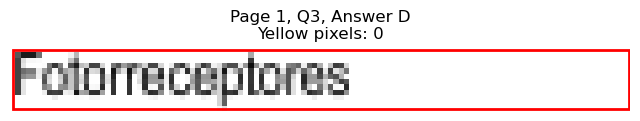


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=343.6, x1=144.5, y1=354.7
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 383
Page 1, Q4, A: Yellow percentage: 0.0%


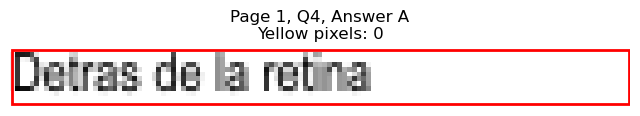

Page 1, Q4 - B: Detected box: x0=68.3, y0=356.2, x1=116.4, y1=367.3
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 236
Page 1, Q4, B: Yellow percentage: 0.0%


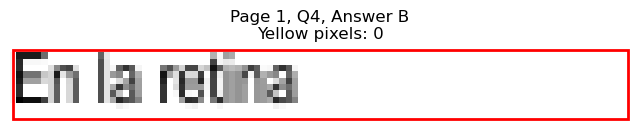

Page 1, Q4 - C: Detected box: x0=327.5, y0=343.6, x1=442.8, y1=354.7
Page 1, Q4, C: Yellow pixels: 166
Page 1, Q4, C: Total non-white pixels: 732
Page 1, Q4, C: Yellow percentage: 22.7%


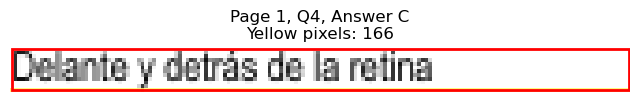

Page 1, Q4 - D: Detected box: x0=327.5, y0=356.2, x1=408.2, y1=367.3
Page 1, Q4, D: Yellow pixels: 1139
Page 1, Q4, D: Total non-white pixels: 1584
Page 1, Q4, D: Yellow percentage: 71.9%


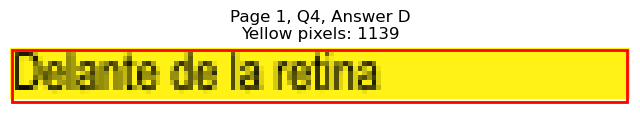


Page 1, Q4 - Selected Answer: D (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=109.9, y1=417.7
Page 1, Q5, A: Yellow pixels: 937
Page 1, Q5, A: Total non-white pixels: 1104
Page 1, Q5, A: Yellow percentage: 84.9%


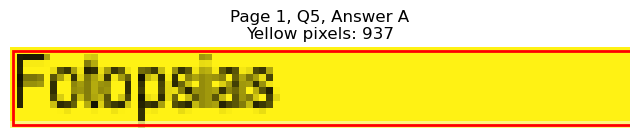

Page 1, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=139.0, y1=430.4
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 357
Page 1, Q5, B: Yellow percentage: 0.0%


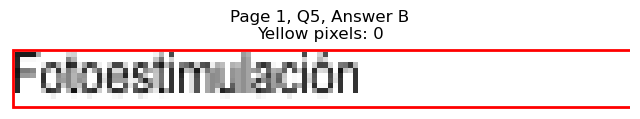

Page 1, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=416.3, y1=417.7
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 465
Page 1, Q5, C: Yellow percentage: 0.0%


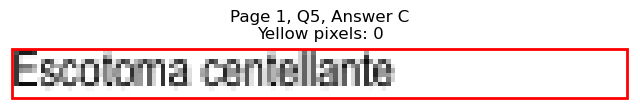

Page 1, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=372.6, y1=430.4
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 234
Page 1, Q5, D: Yellow percentage: 0.0%


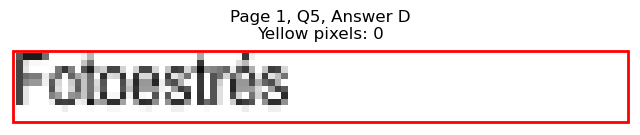


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=469.8, x1=94.3, y1=480.8
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 146
Page 1, Q6, A: Yellow percentage: 0.0%


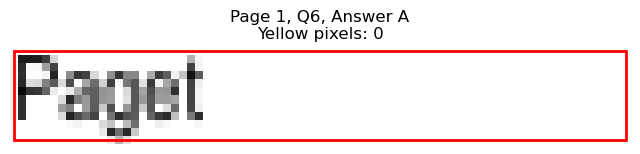

Page 1, Q6 - B: Detected box: x0=68.3, y0=482.5, x1=93.8, y1=493.5
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 120
Page 1, Q6, B: Yellow percentage: 0.0%


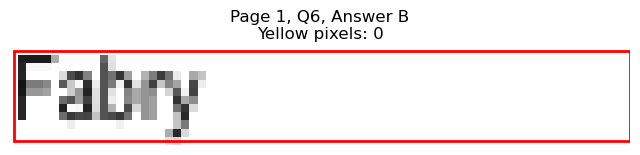

Page 1, Q6 - C: Detected box: x0=327.5, y0=469.8, x1=345.0, y1=480.8
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 137
Page 1, Q6, C: Yellow percentage: 0.0%


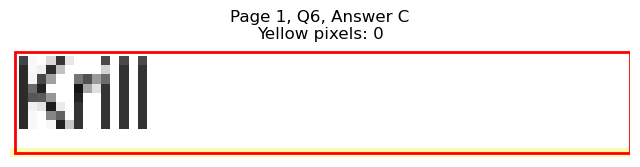

Page 1, Q6 - D: Detected box: x0=327.5, y0=482.5, x1=358.6, y1=493.5
Page 1, Q6, D: Yellow pixels: 792
Page 1, Q6, D: Total non-white pixels: 984
Page 1, Q6, D: Yellow percentage: 80.5%


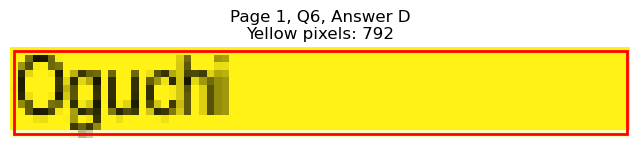


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=532.9, x1=130.4, y1=543.9
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 327
Page 1, Q7, A: Yellow percentage: 0.0%


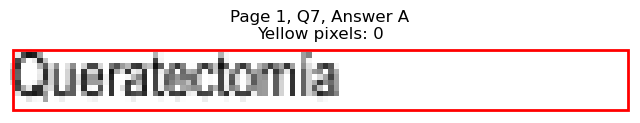

Page 1, Q7 - B: Detected box: x0=68.3, y0=545.5, x1=123.0, y1=556.5
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 299
Page 1, Q7, B: Yellow percentage: 0.0%


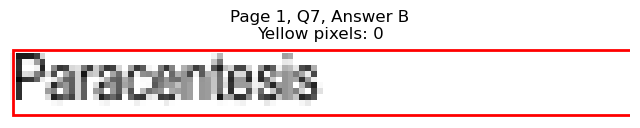

Page 1, Q7 - C: Detected box: x0=327.5, y0=532.9, x1=373.6, y1=543.9
Page 1, Q7, C: Yellow pixels: 986
Page 1, Q7, C: Total non-white pixels: 1164
Page 1, Q7, C: Yellow percentage: 84.7%


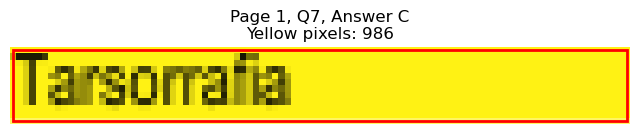

Page 1, Q7 - D: Detected box: x0=327.5, y0=545.5, x1=374.2, y1=556.5
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 263
Page 1, Q7, D: Yellow percentage: 0.0%


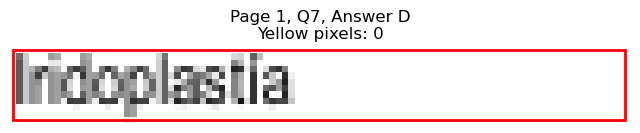


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=583.4, x1=330.0, y1=594.4
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 1333
Page 1, Q8, A: Yellow percentage: 0.0%


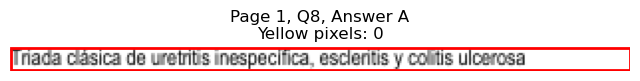

Page 1, Q8 - B: Detected box: x0=68.3, y0=596.0, x1=384.7, y1=607.0
Page 1, Q8, B: Yellow pixels: 367
Page 1, Q8, B: Total non-white pixels: 2232
Page 1, Q8, B: Yellow percentage: 16.4%


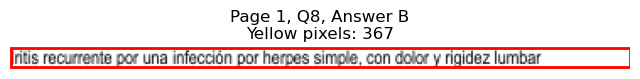

Page 1, Q8 - C: Detected box: x0=68.8, y0=608.6, x1=363.2, y1=619.6
Page 1, Q8, C: Yellow pixels: 3065
Page 1, Q8, C: Total non-white pixels: 4152
Page 1, Q8, C: Yellow percentage: 73.8%


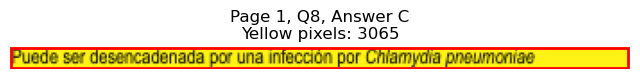

Page 1, Q8 - D: Detected box: x0=68.8, y0=621.3, x1=394.2, y1=632.4
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 1627
Page 1, Q8, D: Yellow percentage: 0.0%


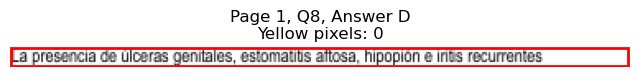


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=697.0, x1=194.6, y1=708.1
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 637
Page 1, Q9, A: Yellow percentage: 0.0%


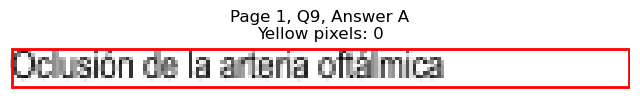

Page 1, Q9 - B: Detected box: x0=68.3, y0=709.6, x1=232.8, y1=720.7
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 807
Page 1, Q9, B: Yellow percentage: 0.0%


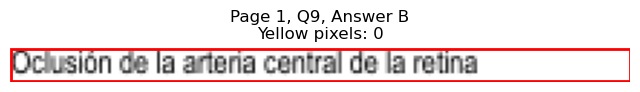

Page 1, Q9 - C: Detected box: x0=327.5, y0=697.0, x1=481.4, y1=708.1
Page 1, Q9, C: Yellow pixels: 1628
Page 1, Q9, C: Total non-white pixels: 2262
Page 1, Q9, C: Yellow percentage: 72.0%


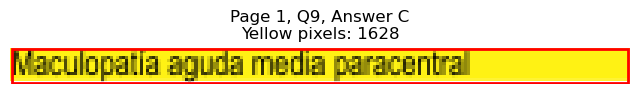

Page 1, Q9 - D: Detected box: x0=327.5, y0=709.6, x1=477.1, y1=720.7
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 746
Page 1, Q9, D: Yellow percentage: 0.0%


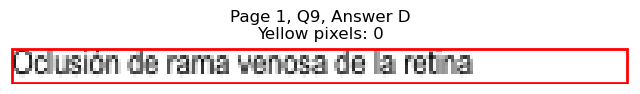


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 11 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=220.8, y1=114.8
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 788
Page 2, Q1, A: Yellow percentage: 0.0%


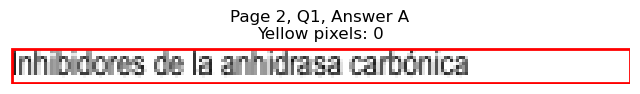

Page 2, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=170.0, y1=127.4
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 507
Page 2, Q1, B: Yellow percentage: 0.0%


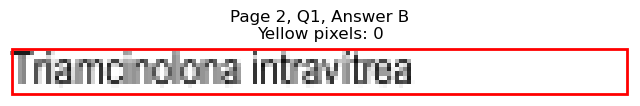

Page 2, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=454.0, y1=114.8
Page 2, Q1, C: Yellow pixels: 1647
Page 2, Q1, C: Total non-white pixels: 2124
Page 2, Q1, C: Yellow percentage: 77.5%


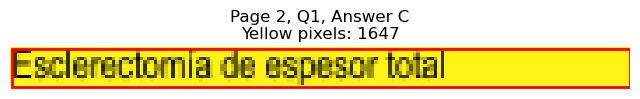

Page 2, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=406.2, y1=127.4
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 391
Page 2, Q1, D: Yellow percentage: 0.0%


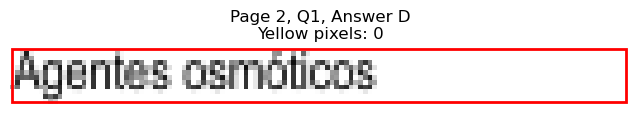


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=97.3, y1=177.9
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 145
Page 2, Q2, A: Yellow percentage: 0.0%


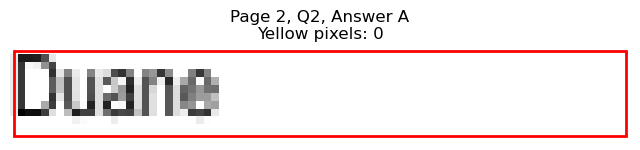

Page 2, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=117.0, y1=190.5
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 240
Page 2, Q2, B: Yellow percentage: 0.0%


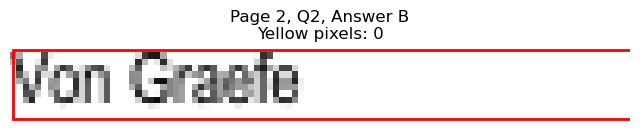

Page 2, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=355.6, y1=177.9
Page 2, Q2, C: Yellow pixels: 842
Page 2, Q2, C: Total non-white pixels: 948
Page 2, Q2, C: Yellow percentage: 88.8%


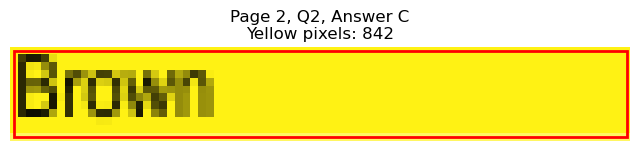

Page 2, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=359.0, y1=190.5
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 175
Page 2, Q2, D: Yellow percentage: 0.0%


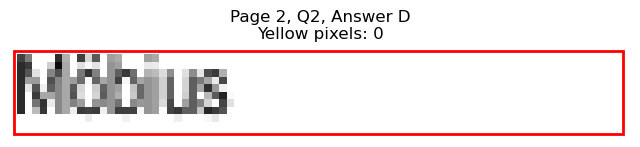


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=275.0, y1=228.4
Page 2, Q3, A: Yellow pixels: 107
Page 2, Q3, A: Total non-white pixels: 1231
Page 2, Q3, A: Yellow percentage: 8.7%


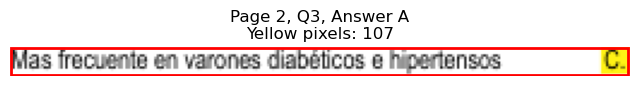

Page 2, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=212.3, y1=241.0
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 709
Page 2, Q3, B: Yellow percentage: 0.0%


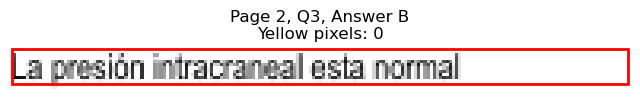

Page 2, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=499.4, y1=228.4
Page 2, Q3, C: Yellow pixels: 1690
Page 2, Q3, C: Total non-white pixels: 2556
Page 2, Q3, C: Yellow percentage: 66.1%


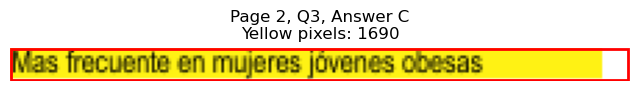

Page 2, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=428.8, y1=241.0
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 519
Page 2, Q3, D: Yellow percentage: 0.0%


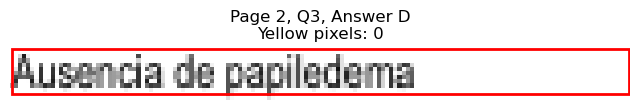


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=267.8, x1=106.4, y1=278.8
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 193
Page 2, Q4, A: Yellow percentage: 0.0%


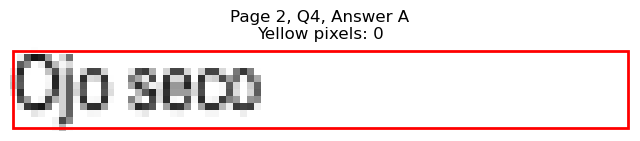

Page 2, Q4 - B: Detected box: x0=68.3, y0=280.5, x1=151.6, y1=291.6
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 447
Page 2, Q4, B: Yellow percentage: 0.0%


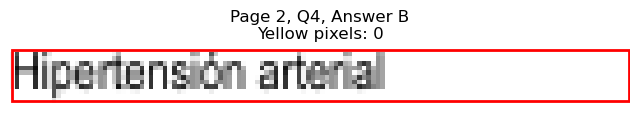

Page 2, Q4 - C: Detected box: x0=327.5, y0=267.8, x1=362.6, y1=278.8
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 288
Page 2, Q4, C: Yellow percentage: 0.0%


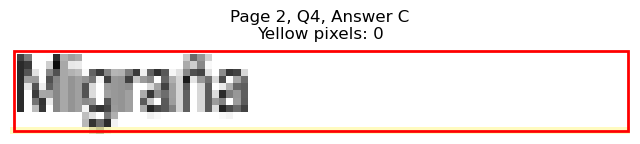

Page 2, Q4 - D: Detected box: x0=327.5, y0=280.5, x1=384.6, y1=291.6
Page 2, Q4, D: Yellow pixels: 933
Page 2, Q4, D: Total non-white pixels: 1296
Page 2, Q4, D: Yellow percentage: 72.0%


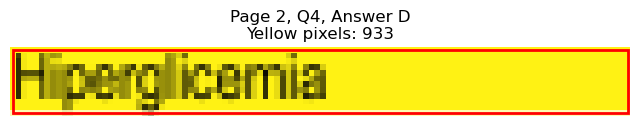


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=330.9, x1=89.4, y1=342.0
Page 2, Q5, A: Yellow pixels: 781
Page 2, Q5, A: Total non-white pixels: 864
Page 2, Q5, A: Yellow percentage: 90.4%


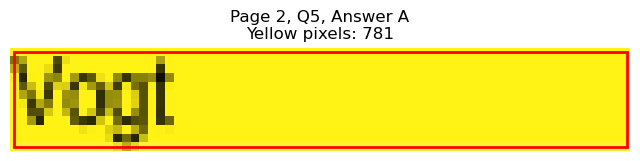

Page 2, Q5 - B: Detected box: x0=68.3, y0=343.6, x1=92.4, y1=354.7
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 124
Page 2, Q5, B: Yellow percentage: 0.0%


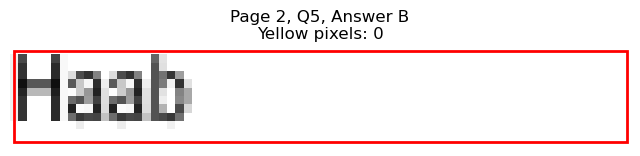

Page 2, Q5 - C: Detected box: x0=327.5, y0=330.9, x1=366.6, y1=342.0
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 211
Page 2, Q5, C: Yellow percentage: 0.0%


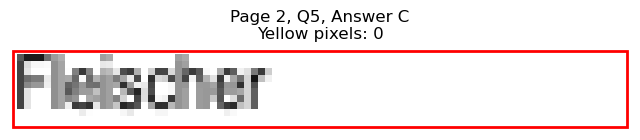

Page 2, Q5 - D: Detected box: x0=327.5, y0=343.6, x1=362.0, y1=354.7
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 164
Page 2, Q5, D: Yellow percentage: 0.0%


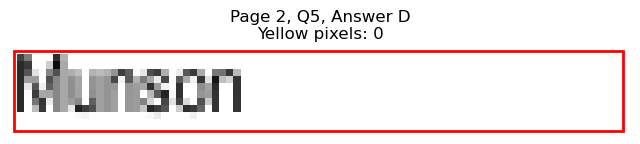


Page 2, Q5 - Selected Answer: A (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=406.6, x1=299.5, y1=417.7
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 1171
Page 2, Q6, A: Yellow percentage: 0.0%


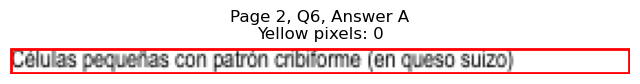

Page 2, Q6 - B: Detected box: x0=68.3, y0=419.4, x1=299.4, y1=430.4
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 1216
Page 2, Q6, B: Yellow percentage: 0.0%


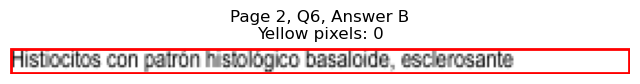

Page 2, Q6 - C: Detected box: x0=68.8, y0=432.0, x1=384.2, y1=443.0
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 1963
Page 2, Q6, C: Yellow percentage: 0.0%


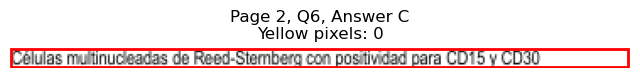

Page 2, Q6 - D: Detected box: x0=68.8, y0=444.6, x1=342.5, y1=455.6
Page 2, Q6, D: Yellow pixels: 2550
Page 2, Q6, D: Total non-white pixels: 3900
Page 2, Q6, D: Yellow percentage: 65.4%


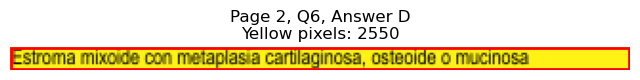


Page 2, Q6 - Selected Answer: D (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=507.7, x1=148.0, y1=518.7
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 404
Page 2, Q7, A: Yellow percentage: 0.0%


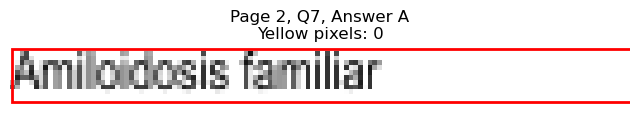

Page 2, Q7 - B: Detected box: x0=68.3, y0=520.3, x1=176.6, y1=531.3
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 546
Page 2, Q7, B: Yellow percentage: 0.0%


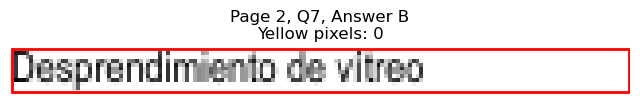

Page 2, Q7 - C: Detected box: x0=327.5, y0=507.7, x1=417.7, y1=518.7
Page 2, Q7, C: Yellow pixels: 1321
Page 2, Q7, C: Total non-white pixels: 1692
Page 2, Q7, C: Yellow percentage: 78.1%


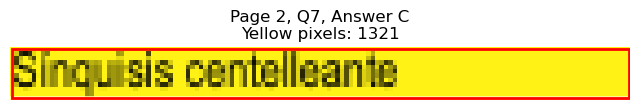

Page 2, Q7 - D: Detected box: x0=327.5, y0=520.3, x1=406.2, y1=531.3
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 422
Page 2, Q7, D: Yellow percentage: 0.0%


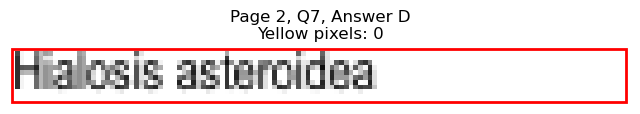


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=558.2, x1=129.5, y1=569.2
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 311
Page 2, Q8, A: Yellow percentage: 0.0%


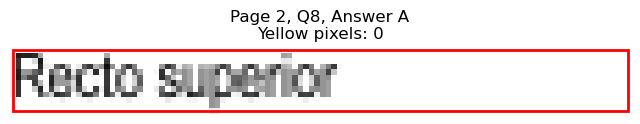

Page 2, Q8 - B: Detected box: x0=68.3, y0=570.8, x1=136.4, y1=581.8
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 344
Page 2, Q8, B: Yellow percentage: 0.0%


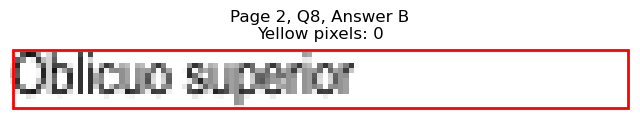

Page 2, Q8 - C: Detected box: x0=327.5, y0=558.2, x1=390.7, y1=569.2
Page 2, Q8, C: Yellow pixels: 1028
Page 2, Q8, C: Total non-white pixels: 1254
Page 2, Q8, C: Yellow percentage: 82.0%


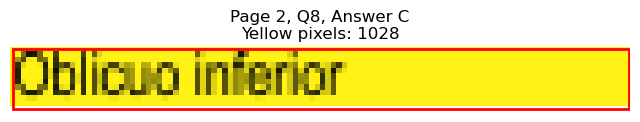

Page 2, Q8 - D: Detected box: x0=327.5, y0=570.8, x1=380.6, y1=581.8
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 266
Page 2, Q8, D: Yellow percentage: 0.0%


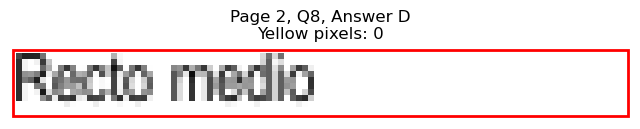


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=93.8, y1=619.6
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 118
Page 2, Q9, A: Yellow percentage: 0.0%


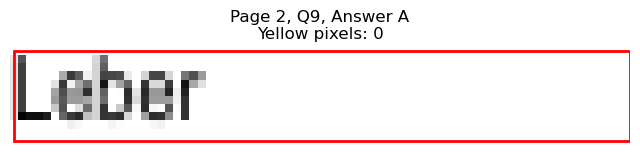

Page 2, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=93.8, y1=632.4
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 119
Page 2, Q9, B: Yellow percentage: 0.0%


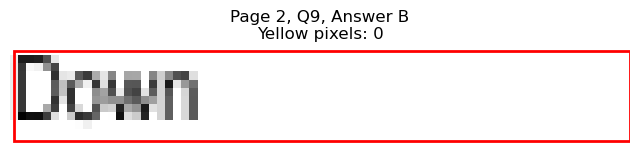

Page 2, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=354.0, y1=619.6
Page 2, Q9, C: Yellow pixels: 835
Page 2, Q9, C: Total non-white pixels: 924
Page 2, Q9, C: Yellow percentage: 90.4%


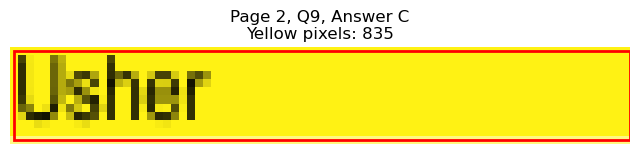

Page 2, Q9 - D: Detected box: x0=327.5, y0=621.3, x1=360.1, y1=632.4
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 169
Page 2, Q9, D: Yellow percentage: 0.0%


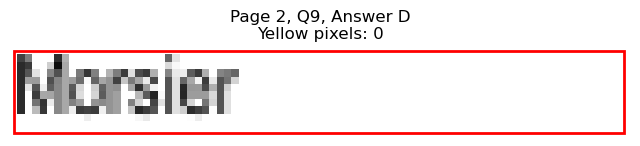


Page 2, Q9 - Selected Answer: C (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=671.7, x1=119.4, y1=682.8
Page 2, Q10, A: Yellow pixels: 102
Page 2, Q10, A: Total non-white pixels: 344
Page 2, Q10, A: Yellow percentage: 29.7%


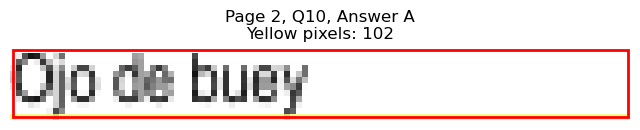

Page 2, Q10 - B: Detected box: x0=68.3, y0=684.3, x1=129.5, y1=695.4
Page 2, Q10, B: Yellow pixels: 967
Page 2, Q10, B: Total non-white pixels: 1344
Page 2, Q10, B: Yellow percentage: 71.9%


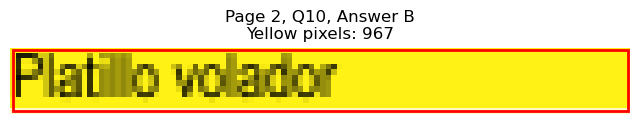

Page 2, Q10 - C: Detected box: x0=327.5, y0=671.7, x1=419.8, y1=682.8
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 457
Page 2, Q10, C: Yellow percentage: 0.0%


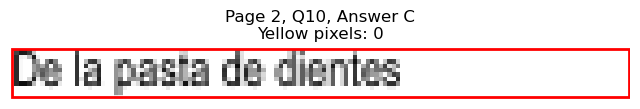

Page 2, Q10 - D: Detected box: x0=327.5, y0=684.3, x1=380.2, y1=695.4
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 264
Page 2, Q10, D: Yellow percentage: 0.0%


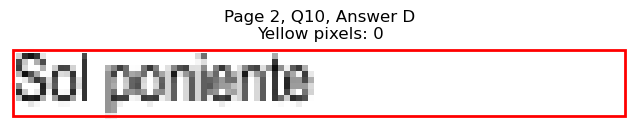


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)




Page 2, Q11 - A: Detected box: x0=68.3, y0=734.8, x1=98.4, y1=745.9
Page 2, Q11, A: Yellow pixels: 859
Page 2, Q11, A: Total non-white pixels: 972
Page 2, Q11, A: Yellow percentage: 88.4%


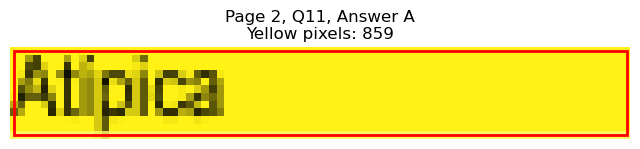

Page 2, Q11 - B: Detected box: x0=68.3, y0=747.4, x1=133.0, y1=758.5
Page 2, Q11, B: Yellow pixels: 0
Page 2, Q11, B: Total non-white pixels: 357
Page 2, Q11, B: Yellow percentage: 0.0%


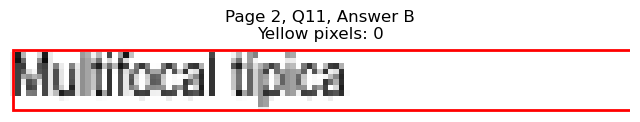

Page 2, Q11 - C: Detected box: x0=327.5, y0=734.8, x1=362.6, y1=745.9
Page 2, Q11, C: Yellow pixels: 0
Page 2, Q11, C: Total non-white pixels: 191
Page 2, Q11, C: Yellow percentage: 0.0%


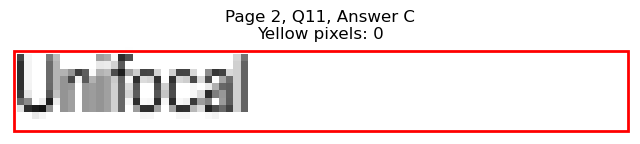

Page 2, Q11 - D: Detected box: x0=327.5, y0=747.4, x1=409.8, y1=758.5
Page 2, Q11, D: Yellow pixels: 0
Page 2, Q11, D: Total non-white pixels: 425
Page 2, Q11, D: Yellow percentage: 0.0%


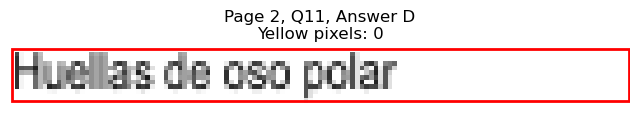


Page 2, Q11 - Selected Answer: A (based on yellow pixel count)





Page 3: Found 11 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=180.6, y1=114.8
Page 3, Q1, A: Yellow pixels: 163
Page 3, Q1, A: Total non-white pixels: 730
Page 3, Q1, A: Yellow percentage: 22.3%


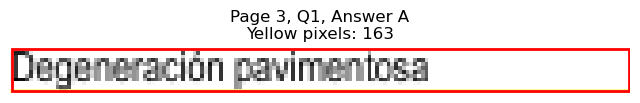

Page 3, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=136.4, y1=127.4
Page 3, Q1, B: Yellow pixels: 1024
Page 3, Q1, B: Total non-white pixels: 1428
Page 3, Q1, B: Yellow percentage: 71.7%


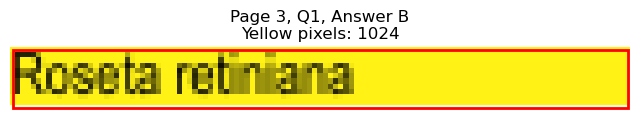

Page 3, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=402.7, y1=114.8
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 402
Page 3, Q1, C: Yellow percentage: 0.0%


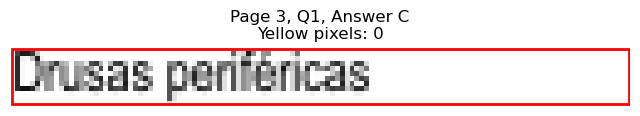

Page 3, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=423.2, y1=127.4
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 507
Page 3, Q1, D: Yellow percentage: 0.0%


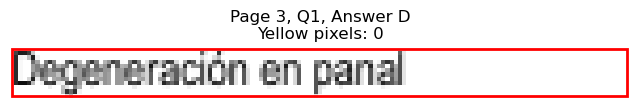


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=152.0, y1=165.3
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 413
Page 3, Q2, A: Yellow percentage: 0.0%


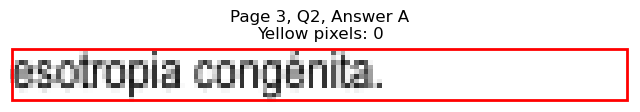

Page 3, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=160.1, y1=177.9
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 443
Page 3, Q2, B: Yellow percentage: 0.0%


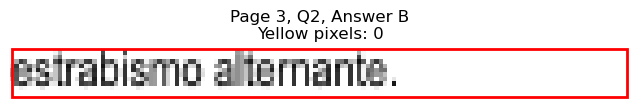

Page 3, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=439.8, y1=165.3
Page 3, Q2, C: Yellow pixels: 1383
Page 3, Q2, C: Total non-white pixels: 1956
Page 3, Q2, C: Yellow percentage: 70.7%


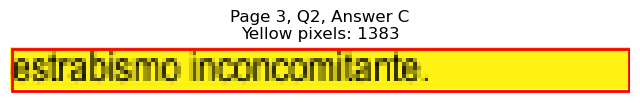

Page 3, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=418.8, y1=177.9
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 471
Page 3, Q2, D: Yellow percentage: 0.0%


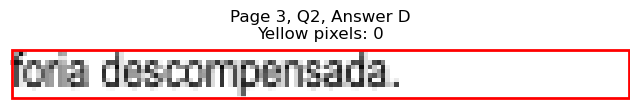


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=204.7, x1=121.4, y1=215.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 274
Page 3, Q3, A: Yellow percentage: 0.0%


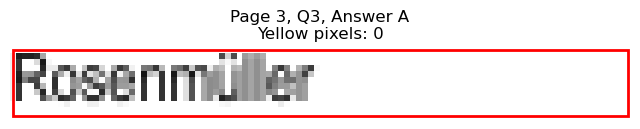

Page 3, Q3 - B: Detected box: x0=68.3, y0=217.4, x1=107.4, y1=228.4
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 211
Page 3, Q3, B: Yellow percentage: 0.0%


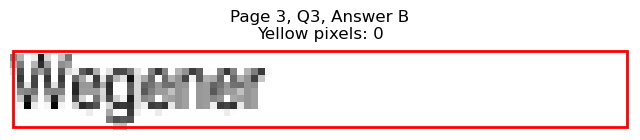

Page 3, Q3 - C: Detected box: x0=327.5, y0=204.7, x1=351.6, y1=215.7
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 175
Page 3, Q3, C: Yellow percentage: 0.0%


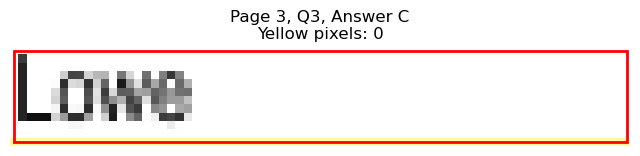

Page 3, Q3 - D: Detected box: x0=327.5, y0=217.4, x1=359.0, y1=228.4
Page 3, Q3, D: Yellow pixels: 795
Page 3, Q3, D: Total non-white pixels: 996
Page 3, Q3, D: Yellow percentage: 79.8%


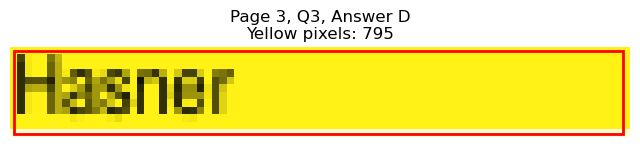


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=255.2, x1=130.4, y1=266.2
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 321
Page 3, Q4, A: Yellow percentage: 0.0%


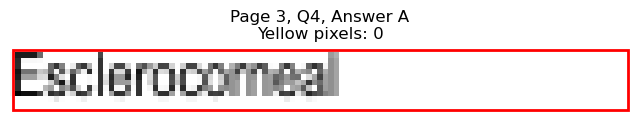

Page 3, Q4 - B: Detected box: x0=68.3, y0=267.8, x1=93.8, y1=278.8
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 117
Page 3, Q4, B: Yellow percentage: 0.0%


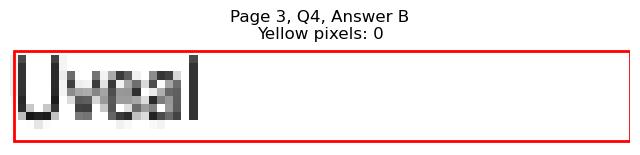

Page 3, Q4 - C: Detected box: x0=327.5, y0=255.2, x1=396.2, y1=266.2
Page 3, Q4, C: Yellow pixels: 1063
Page 3, Q4, C: Total non-white pixels: 1320
Page 3, Q4, C: Yellow percentage: 80.5%


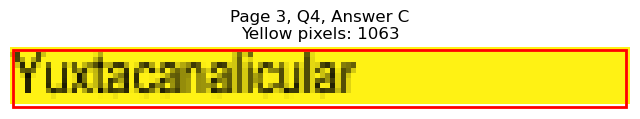

Page 3, Q4 - D: Detected box: x0=327.5, y0=267.8, x1=365.6, y1=278.8
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 204
Page 3, Q4, D: Yellow percentage: 0.0%


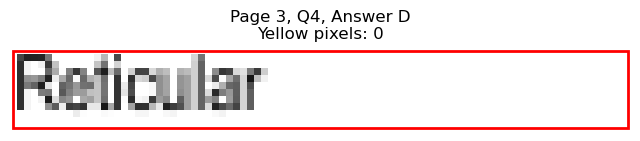


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=318.3, x1=127.0, y1=329.4
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 299
Page 3, Q5, A: Yellow percentage: 0.0%


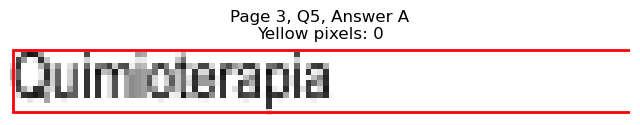

Page 3, Q5 - B: Detected box: x0=68.3, y0=330.9, x1=174.1, y1=342.0
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 555
Page 3, Q5, B: Yellow percentage: 0.0%


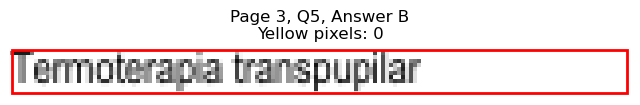

Page 3, Q5 - C: Detected box: x0=327.5, y0=318.3, x1=383.6, y1=329.4
Page 3, Q5, C: Yellow pixels: 107
Page 3, Q5, C: Total non-white pixels: 398
Page 3, Q5, C: Yellow percentage: 26.9%


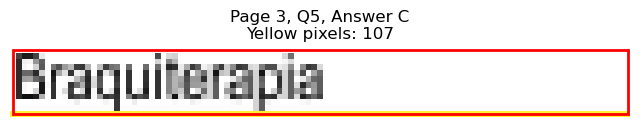

Page 3, Q5 - D: Detected box: x0=327.5, y0=330.9, x1=413.8, y1=342.0
Page 3, Q5, D: Yellow pixels: 1289
Page 3, Q5, D: Total non-white pixels: 1644
Page 3, Q5, D: Yellow percentage: 78.4%


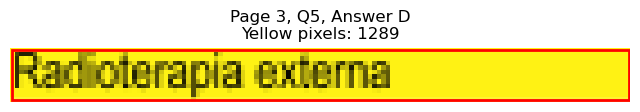


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=368.8, x1=142.6, y1=379.9
Page 3, Q6, A: Yellow pixels: 1190
Page 3, Q6, A: Total non-white pixels: 1500
Page 3, Q6, A: Yellow percentage: 79.3%


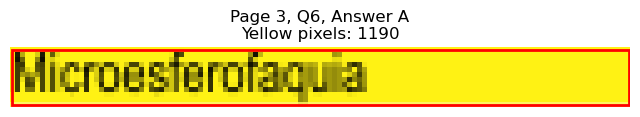

Page 3, Q6 - B: Detected box: x0=68.3, y0=381.4, x1=127.4, y1=392.5
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 328
Page 3, Q6, B: Yellow percentage: 0.0%


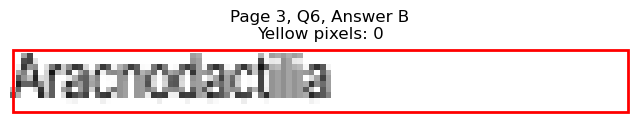

Page 3, Q6 - C: Detected box: x0=327.5, y0=368.8, x1=366.6, y1=379.9
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 196
Page 3, Q6, C: Yellow percentage: 0.0%


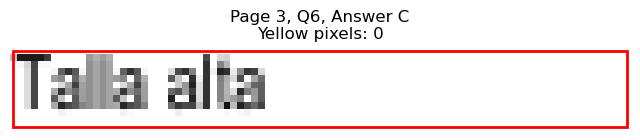

Page 3, Q6 - D: Detected box: x0=327.5, y0=381.4, x1=396.7, y1=392.5
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 361
Page 3, Q6, D: Yellow percentage: 0.0%


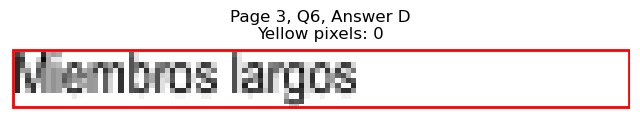


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=419.4, x1=324.6, y1=430.4
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 1253
Page 3, Q7, A: Yellow percentage: 0.0%


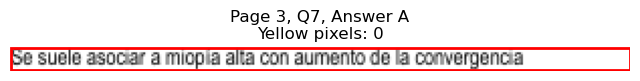

Page 3, Q7 - B: Detected box: x0=68.3, y0=432.0, x1=327.5, y1=443.0
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 1588
Page 3, Q7, B: Yellow percentage: 0.0%


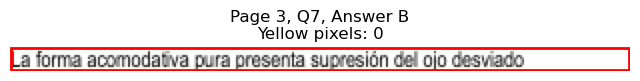

Page 3, Q7 - C: Detected box: x0=68.8, y0=444.6, x1=323.5, y1=455.6
Page 3, Q7, C: Yellow pixels: 2409
Page 3, Q7, C: Total non-white pixels: 3672
Page 3, Q7, C: Yellow percentage: 65.6%


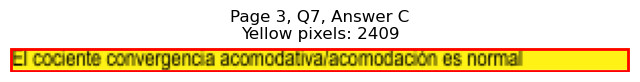

Page 3, Q7 - D: Detected box: x0=68.8, y0=457.2, x1=348.6, y1=468.2
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 1439
Page 3, Q7, D: Yellow percentage: 0.0%


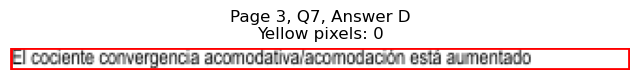


Page 3, Q7 - Selected Answer: C (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=495.1, x1=136.4, y1=506.1
Page 3, Q8, A: Yellow pixels: 119
Page 3, Q8, A: Total non-white pixels: 582
Page 3, Q8, A: Yellow percentage: 20.4%


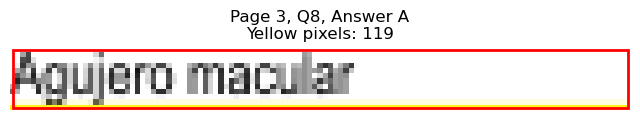

Page 3, Q8 - B: Detected box: x0=68.3, y0=507.7, x1=145.0, y1=518.7
Page 3, Q8, B: Yellow pixels: 1240
Page 3, Q8, B: Total non-white pixels: 1524
Page 3, Q8, B: Yellow percentage: 81.4%


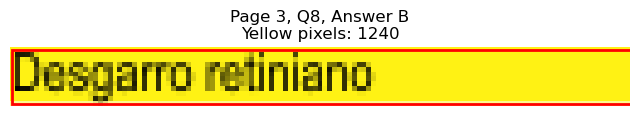

Page 3, Q8 - C: Detected box: x0=327.5, y0=495.1, x1=387.1, y1=506.1
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 319
Page 3, Q8, C: Yellow percentage: 0.0%


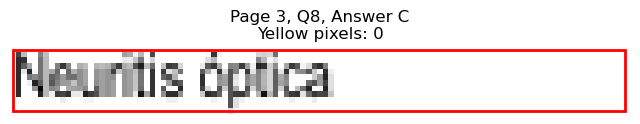

Page 3, Q8 - D: Detected box: x0=327.5, y0=507.7, x1=382.2, y1=518.7
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 272
Page 3, Q8, D: Yellow percentage: 0.0%


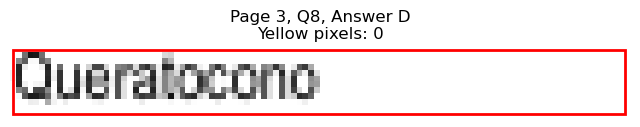


Page 3, Q8 - Selected Answer: B (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=583.4, x1=139.9, y1=594.4
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 375
Page 3, Q9, A: Yellow percentage: 0.0%


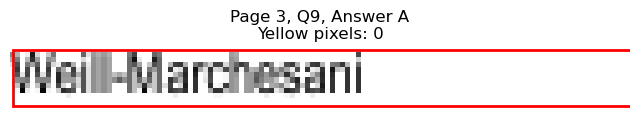

Page 3, Q9 - B: Detected box: x0=68.3, y0=596.0, x1=98.9, y1=607.0
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 157
Page 3, Q9, B: Yellow percentage: 0.0%


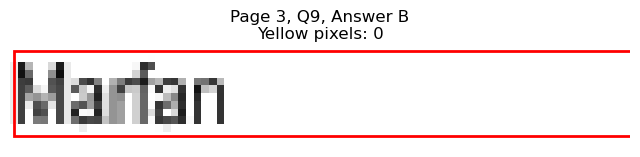

Page 3, Q9 - C: Detected box: x0=327.5, y0=583.4, x1=367.1, y1=594.4
Page 3, Q9, C: Yellow pixels: 91
Page 3, Q9, C: Total non-white pixels: 301
Page 3, Q9, C: Yellow percentage: 30.2%


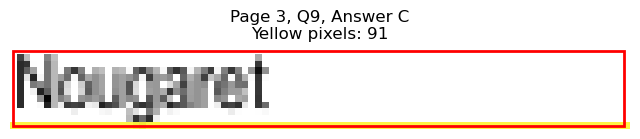

Page 3, Q9 - D: Detected box: x0=327.5, y0=596.0, x1=353.5, y1=607.0
Page 3, Q9, D: Yellow pixels: 835
Page 3, Q9, D: Total non-white pixels: 925
Page 3, Q9, D: Yellow percentage: 90.3%


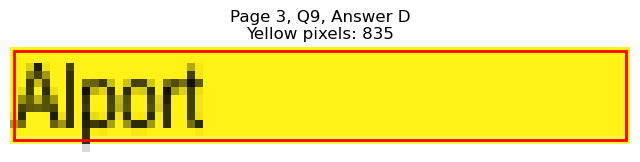


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=633.9, x1=131.5, y1=645.0
Page 3, Q10, A: Yellow pixels: 1126
Page 3, Q10, A: Total non-white pixels: 1368
Page 3, Q10, A: Yellow percentage: 82.3%


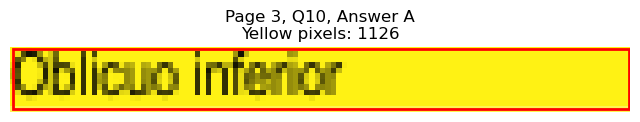

Page 3, Q10 - B: Detected box: x0=68.3, y0=646.5, x1=181.1, y1=657.6
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 561
Page 3, Q10, B: Yellow percentage: 0.0%


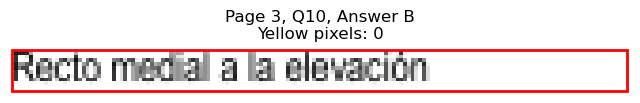

Page 3, Q10 - C: Detected box: x0=327.5, y0=633.9, x1=439.8, y1=645.0
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 574
Page 3, Q10, C: Yellow percentage: 0.0%


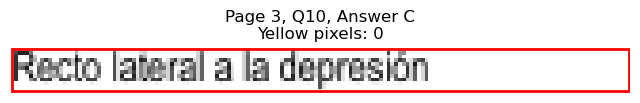

Page 3, Q10 - D: Detected box: x0=327.5, y0=646.5, x1=395.6, y1=657.6
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 339
Page 3, Q10, D: Yellow percentage: 0.0%


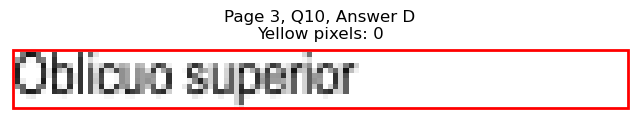


Page 3, Q10 - Selected Answer: A (based on yellow pixel count)




Page 3, Q11 - A: Detected box: x0=68.3, y0=684.3, x1=326.5, y1=695.4
Page 3, Q11, A: Yellow pixels: 2398
Page 3, Q11, A: Total non-white pixels: 3708
Page 3, Q11, A: Yellow percentage: 64.7%


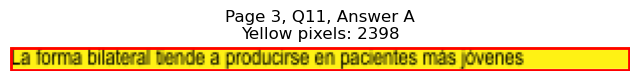

Page 3, Q11 - B: Detected box: x0=68.3, y0=697.0, x1=271.8, y1=708.1
Page 3, Q11, B: Yellow pixels: 0
Page 3, Q11, B: Total non-white pixels: 1004
Page 3, Q11, B: Yellow percentage: 0.0%


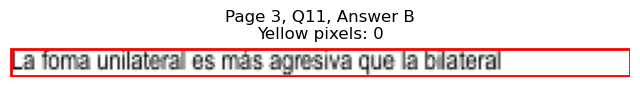

Page 3, Q11 - C: Detected box: x0=68.8, y0=709.6, x1=221.3, y1=720.7
Page 3, Q11, C: Yellow pixels: 0
Page 3, Q11, C: Total non-white pixels: 779
Page 3, Q11, C: Yellow percentage: 0.0%


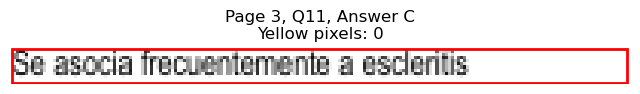

Page 3, Q11 - D: Detected box: x0=68.8, y0=722.2, x1=299.0, y1=733.3
Page 3, Q11, D: Yellow pixels: 0
Page 3, Q11, D: Total non-white pixels: 1114
Page 3, Q11, D: Yellow percentage: 0.0%


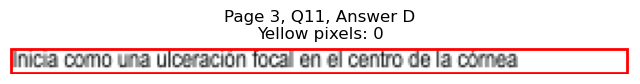


Page 3, Q11 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=83.4, y1=102.2
Page 4, Q1, A: Yellow pixels: 66
Page 4, Q1, A: Total non-white pixels: 203
Page 4, Q1, A: Yellow percentage: 32.5%


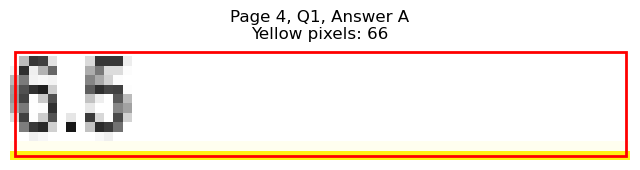

Page 4, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=83.4, y1=114.8
Page 4, Q1, B: Yellow pixels: 759
Page 4, Q1, B: Total non-white pixels: 792
Page 4, Q1, B: Yellow percentage: 95.8%


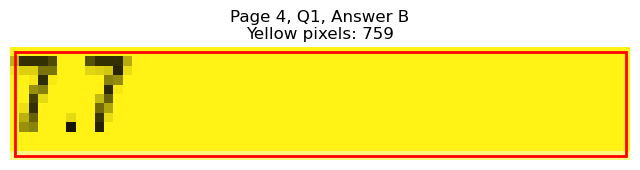

Page 4, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=342.6, y1=102.2
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 75
Page 4, Q1, C: Yellow percentage: 0.0%


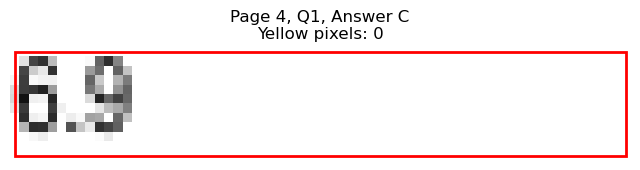

Page 4, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=342.6, y1=114.8
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 72
Page 4, Q1, D: Yellow percentage: 0.0%


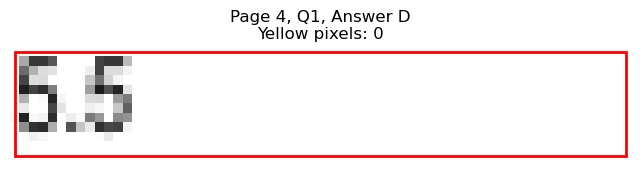


Page 4, Q1 - Selected Answer: B (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=142.4, y1=165.3
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 365
Page 4, Q2, A: Yellow percentage: 0.0%


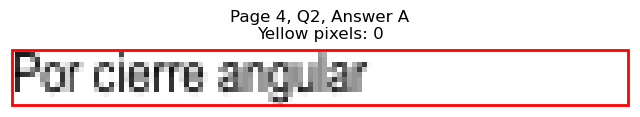

Page 4, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=154.1, y1=177.9
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 408
Page 4, Q2, B: Yellow percentage: 0.0%


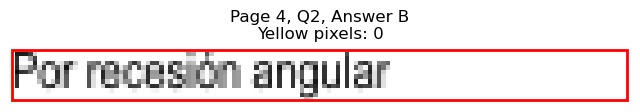

Page 4, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=414.2, y1=165.3
Page 4, Q2, C: Yellow pixels: 138
Page 4, Q2, C: Total non-white pixels: 570
Page 4, Q2, C: Yellow percentage: 24.2%


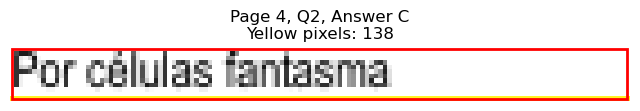

Page 4, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=378.1, y1=177.9
Page 4, Q2, D: Yellow pixels: 1034
Page 4, Q2, D: Total non-white pixels: 1224
Page 4, Q2, D: Yellow percentage: 84.5%


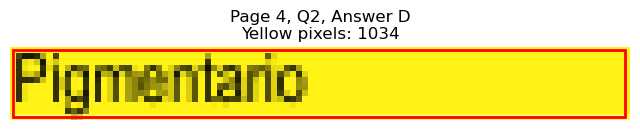


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=97.3, y1=228.4
Page 4, Q3, A: Yellow pixels: 772
Page 4, Q3, A: Total non-white pixels: 960
Page 4, Q3, A: Yellow percentage: 80.4%


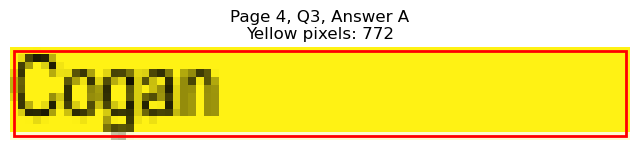

Page 4, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=97.3, y1=241.0
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 145
Page 4, Q3, B: Yellow percentage: 0.0%


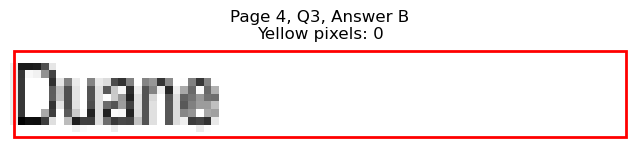

Page 4, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=366.1, y1=228.4
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 176
Page 4, Q3, C: Yellow percentage: 0.0%


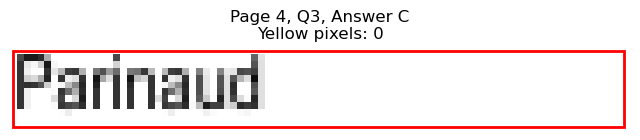

Page 4, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=375.6, y1=241.0
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 274
Page 4, Q3, D: Yellow percentage: 0.0%


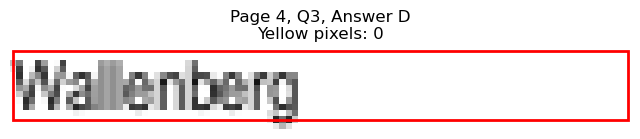


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=107.4, y1=304.2
Page 4, Q4, A: Yellow pixels: 835
Page 4, Q4, A: Total non-white pixels: 990
Page 4, Q4, A: Yellow percentage: 84.3%


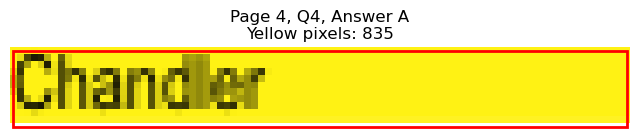

Page 4, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=130.0, y1=316.8
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 312
Page 4, Q4, B: Yellow percentage: 0.0%


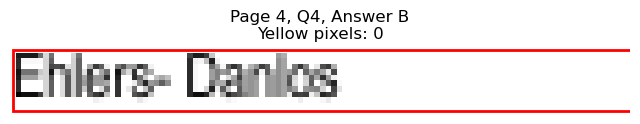

Page 4, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=372.1, y1=304.2
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 218
Page 4, Q4, C: Yellow percentage: 0.0%


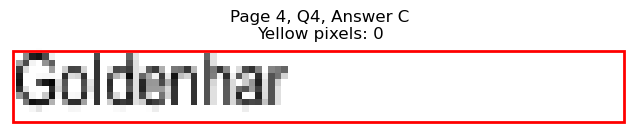

Page 4, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=376.1, y1=316.8
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 233
Page 4, Q4, D: Yellow percentage: 0.0%


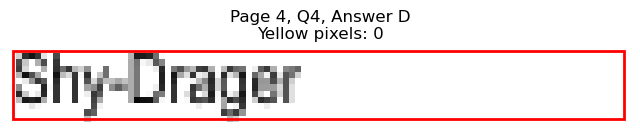


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=56.6, y0=343.6, x1=65.2, y1=354.7
Page 4, Q5, A: Yellow pixels: 60
Page 4, Q5, A: Total non-white pixels: 120
Page 4, Q5, A: Yellow percentage: 50.0%


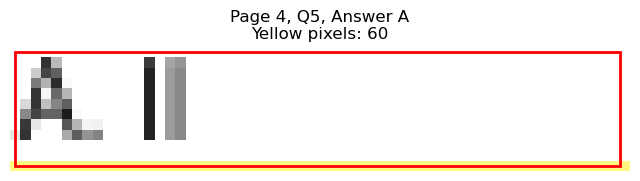

Page 4, Q5 - B: Detected box: x0=68.3, y0=356.2, x1=78.4, y1=367.3
Page 4, Q5, B: Yellow pixels: 639
Page 4, Q5, B: Total non-white pixels: 732
Page 4, Q5, B: Yellow percentage: 87.3%


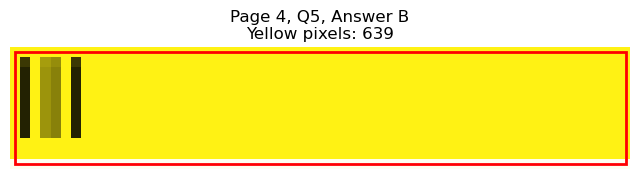

Page 4, Q5 - C: Detected box: x0=327.5, y0=343.6, x1=338.5, y1=354.7
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 43
Page 4, Q5, C: Yellow percentage: 0.0%


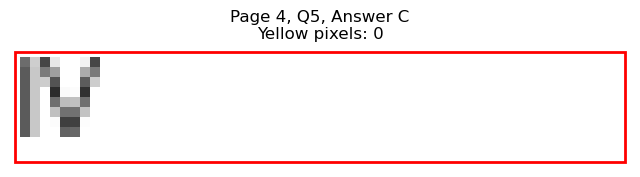

Page 4, Q5 - D: Detected box: x0=315.4, y0=356.2, x1=324.4, y1=367.3
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 71
Page 4, Q5, D: Yellow percentage: 0.0%


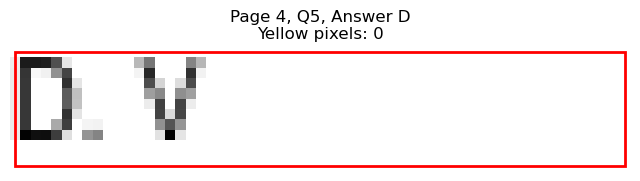


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=394.0, x1=121.9, y1=405.1
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 285
Page 4, Q6, A: Yellow percentage: 0.0%


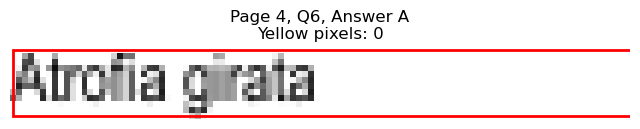

Page 4, Q6 - B: Detected box: x0=68.3, y0=406.6, x1=124.9, y1=417.7
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 284
Page 4, Q6, B: Yellow percentage: 0.0%


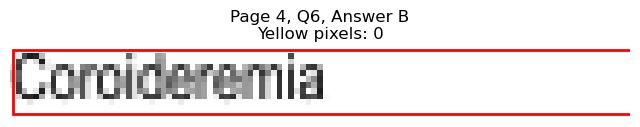

Page 4, Q6 - C: Detected box: x0=327.5, y0=394.0, x1=506.0, y1=405.1
Page 4, Q6, C: Yellow pixels: 1683
Page 4, Q6, C: Total non-white pixels: 2349
Page 4, Q6, C: Yellow percentage: 71.6%


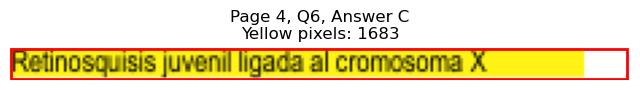

Page 4, Q6 - D: Detected box: x0=327.5, y0=406.6, x1=472.0, y1=417.7
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 734
Page 4, Q6, D: Yellow percentage: 0.0%


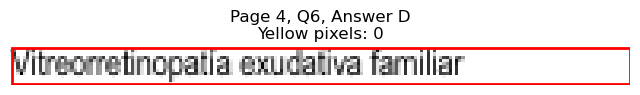


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=444.6, x1=96.4, y1=455.6
Page 4, Q7, A: Yellow pixels: 79
Page 4, Q7, A: Total non-white pixels: 221
Page 4, Q7, A: Yellow percentage: 35.7%


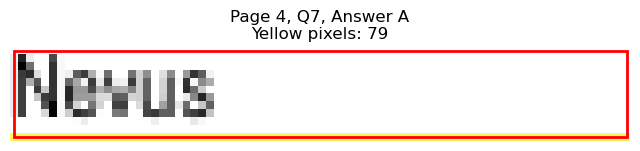

Page 4, Q7 - B: Detected box: x0=68.3, y0=457.2, x1=110.0, y1=468.2
Page 4, Q7, B: Yellow pixels: 874
Page 4, Q7, B: Total non-white pixels: 1023
Page 4, Q7, B: Yellow percentage: 85.4%


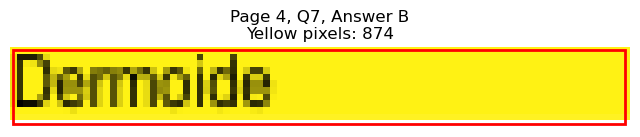

Page 4, Q7 - C: Detected box: x0=327.5, y0=444.6, x1=379.2, y1=455.6
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 253
Page 4, Q7, C: Yellow percentage: 0.0%


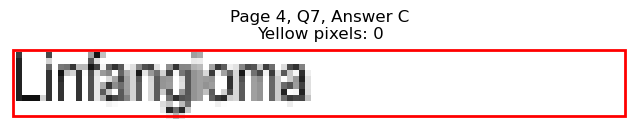

Page 4, Q7 - D: Detected box: x0=327.5, y0=457.2, x1=383.8, y1=468.2
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 279
Page 4, Q7, D: Yellow percentage: 0.0%


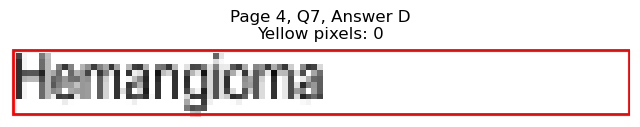


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=507.7, x1=91.3, y1=518.7
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 72
Page 4, Q8, A: Yellow percentage: 0.0%


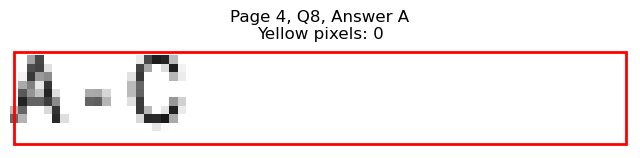

Page 4, Q8 - B: Detected box: x0=68.3, y0=520.3, x1=90.8, y1=531.3
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 63
Page 4, Q8, B: Yellow percentage: 0.0%


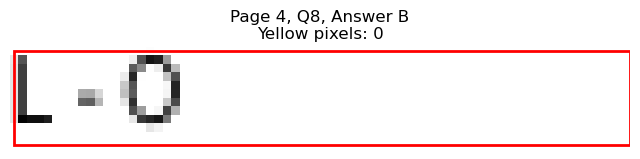

Page 4, Q8 - C: Detected box: x0=327.5, y0=507.7, x1=350.5, y1=518.7
Page 4, Q8, C: Yellow pixels: 826
Page 4, Q8, C: Total non-white pixels: 888
Page 4, Q8, C: Yellow percentage: 93.0%


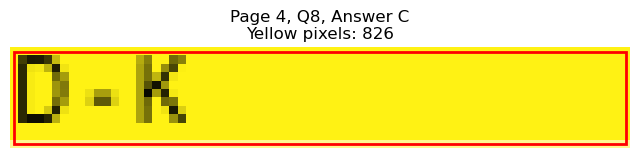

Page 4, Q8 - D: Detected box: x0=327.5, y0=520.3, x1=349.6, y1=531.3
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 60
Page 4, Q8, D: Yellow percentage: 0.0%


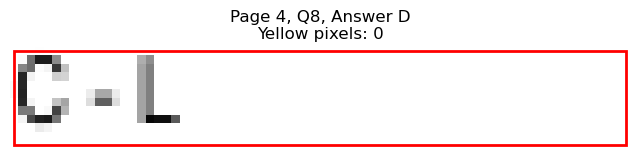


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=583.4, x1=238.4, y1=594.4
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 887
Page 4, Q9, A: Yellow percentage: 0.0%


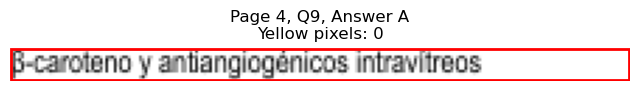

Page 4, Q9 - B: Detected box: x0=68.3, y0=596.0, x1=236.3, y1=607.0
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 866
Page 4, Q9, B: Yellow percentage: 0.0%


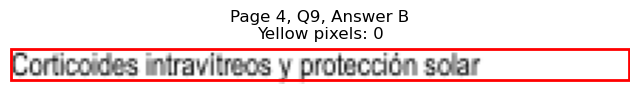

Page 4, Q9 - C: Detected box: x0=327.5, y0=583.4, x1=498.5, y1=594.4
Page 4, Q9, C: Yellow pixels: 1676
Page 4, Q9, C: Total non-white pixels: 2556
Page 4, Q9, C: Yellow percentage: 65.6%


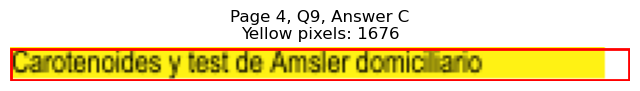

Page 4, Q9 - D: Detected box: x0=327.5, y0=596.0, x1=478.4, y1=607.0
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 745
Page 4, Q9, D: Yellow percentage: 0.0%


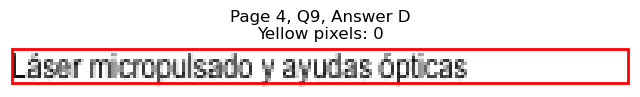


Page 4, Q9 - Selected Answer: C (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=659.1, x1=164.5, y1=670.2
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 474
Page 4, Q10, A: Yellow percentage: 0.0%


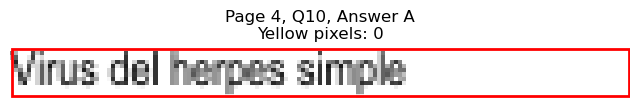

Page 4, Q10 - B: Detected box: x0=68.3, y0=671.7, x1=146.5, y1=682.8
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 403
Page 4, Q10, B: Yellow percentage: 0.0%


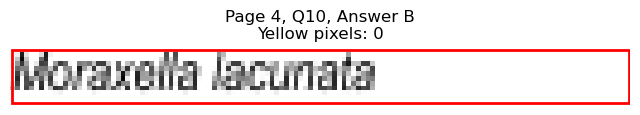

Page 4, Q10 - C: Detected box: x0=327.5, y0=659.1, x1=428.8, y1=670.2
Page 4, Q10, C: Yellow pixels: 152
Page 4, Q10, C: Total non-white pixels: 816
Page 4, Q10, C: Yellow percentage: 18.6%


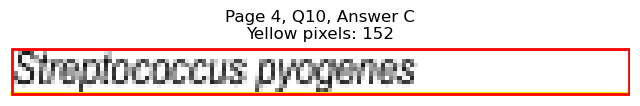

Page 4, Q10 - D: Detected box: x0=327.5, y0=671.7, x1=447.4, y1=682.8
Page 4, Q10, D: Yellow pixels: 1624
Page 4, Q10, D: Total non-white pixels: 2052
Page 4, Q10, D: Yellow percentage: 79.1%


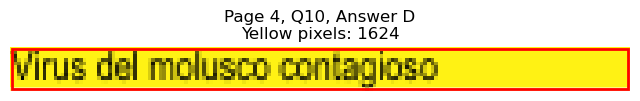


Page 4, Q10 - Selected Answer: D (based on yellow pixel count)




Page 4, Q11 - A: Detected box: x0=68.3, y0=217.4, x1=97.3, y1=228.4
Page 4, Q11, A: Yellow pixels: 772
Page 4, Q11, A: Total non-white pixels: 960
Page 4, Q11, A: Yellow percentage: 80.4%


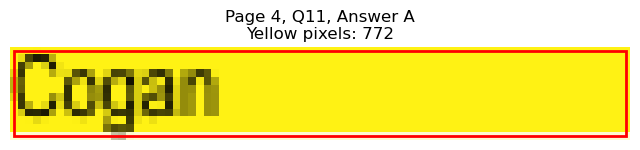

Page 4, Q11 - B: Detected box: x0=68.3, y0=734.8, x1=98.9, y1=745.9
Page 4, Q11, B: Yellow pixels: 862
Page 4, Q11, B: Total non-white pixels: 972
Page 4, Q11, B: Yellow percentage: 88.7%


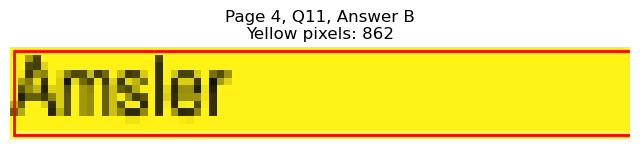

Page 4, Q11 - C: Detected box: x0=327.5, y0=722.2, x1=355.6, y1=733.3
Page 4, Q11, C: Yellow pixels: 0
Page 4, Q11, C: Total non-white pixels: 137
Page 4, Q11, C: Yellow percentage: 0.0%


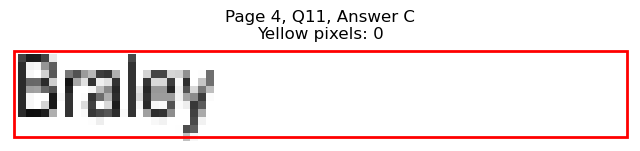

Page 4, Q11 - D: Detected box: x0=327.5, y0=734.8, x1=355.6, y1=745.9
Page 4, Q11, D: Yellow pixels: 0
Page 4, Q11, D: Total non-white pixels: 151
Page 4, Q11, D: Yellow percentage: 0.0%


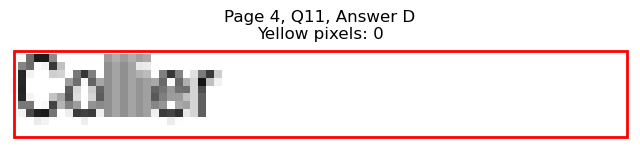


Page 4, Q11 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=163.1, y1=140.0
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 450
Page 5, Q1, A: Yellow percentage: 0.0%


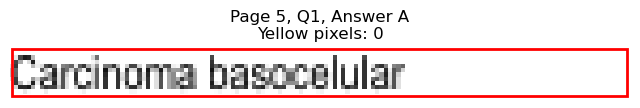

Page 5, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=198.6, y1=152.7
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 634
Page 5, Q1, B: Yellow percentage: 0.0%


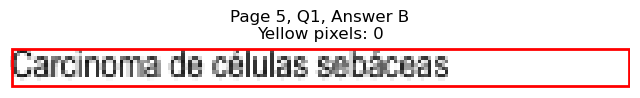

Page 5, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=402.2, y1=140.0
Page 5, Q1, C: Yellow pixels: 1225
Page 5, Q1, C: Total non-white pixels: 1512
Page 5, Q1, C: Yellow percentage: 81.0%


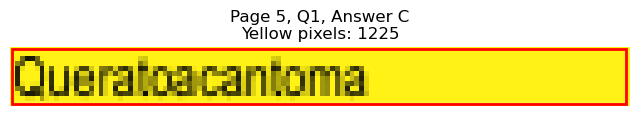

Page 5, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=384.6, y1=152.7
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 289
Page 5, Q1, D: Yellow percentage: 0.0%


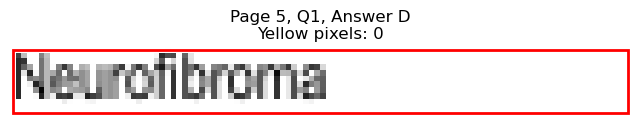


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=417.4, y1=190.5
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 1751
Page 5, Q2, A: Yellow percentage: 0.0%


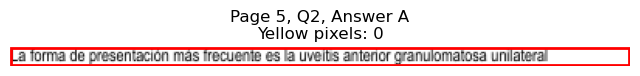

Page 5, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=299.0, y1=203.1
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 1106
Page 5, Q2, B: Yellow percentage: 0.0%


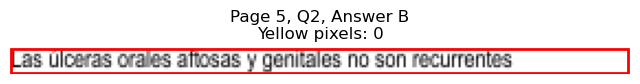

Page 5, Q2 - C: Detected box: x0=68.8, y0=204.7, x1=391.7, y1=215.7
Page 5, Q2, C: Yellow pixels: 2
Page 5, Q2, C: Total non-white pixels: 1953
Page 5, Q2, C: Yellow percentage: 0.1%


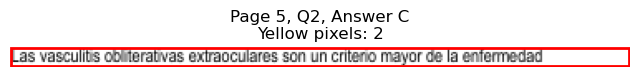

Page 5, Q2 - D: Detected box: x0=68.8, y0=217.4, x1=451.3, y1=228.4
Page 5, Q2, D: Yellow pixels: 3321
Page 5, Q2, D: Total non-white pixels: 5208
Page 5, Q2, D: Yellow percentage: 63.8%


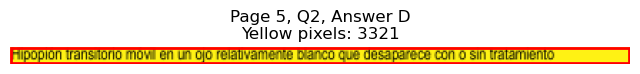


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=211.8, y1=266.2
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 758
Page 5, Q3, A: Yellow percentage: 0.0%


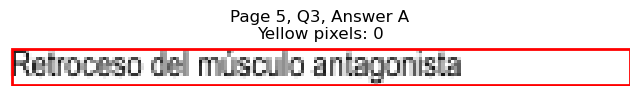

Page 5, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=232.8, y1=278.8
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 850
Page 5, Q3, B: Yellow percentage: 0.0%


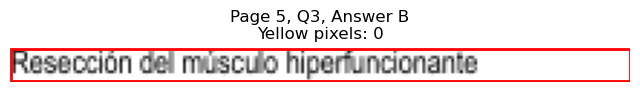

Page 5, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=490.9, y1=266.2
Page 5, Q3, C: Yellow pixels: 1675
Page 5, Q3, C: Total non-white pixels: 2345
Page 5, Q3, C: Yellow percentage: 71.4%


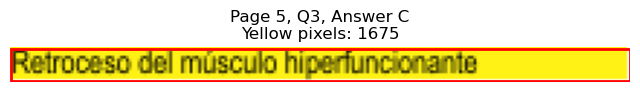

Page 5, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=471.5, y1=278.8
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 766
Page 5, Q3, D: Yellow percentage: 0.0%


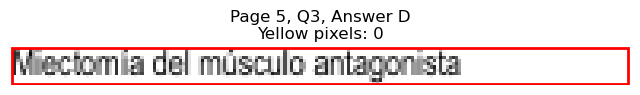


Page 5, Q3 - Selected Answer: C (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=305.7, x1=130.0, y1=316.8
Page 5, Q4, A: Yellow pixels: 112
Page 5, Q4, A: Total non-white pixels: 408
Page 5, Q4, A: Yellow percentage: 27.5%


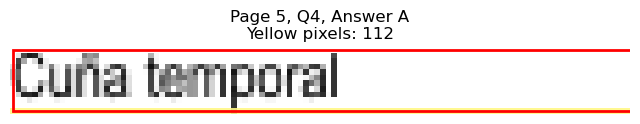

Page 5, Q4 - B: Detected box: x0=68.3, y0=318.3, x1=172.6, y1=329.4
Page 5, Q4, B: Yellow pixels: 1313
Page 5, Q4, B: Total non-white pixels: 1860
Page 5, Q4, B: Yellow percentage: 70.6%


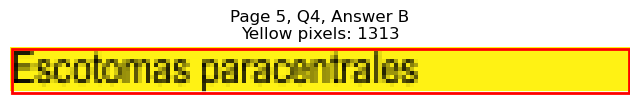

Page 5, Q4 - C: Detected box: x0=327.5, y0=305.7, x1=386.2, y1=316.8
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 292
Page 5, Q4, C: Yellow percentage: 0.0%


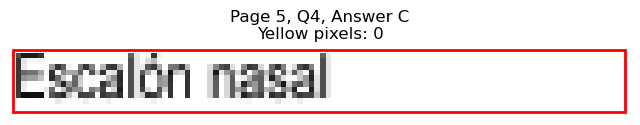

Page 5, Q4 - D: Detected box: x0=327.5, y0=318.3, x1=397.7, y1=329.4
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 353
Page 5, Q4, D: Yellow percentage: 0.0%


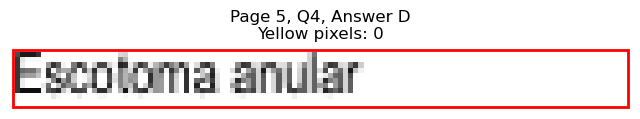


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=368.8, x1=146.0, y1=379.9
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 372
Page 5, Q5, A: Yellow percentage: 0.0%


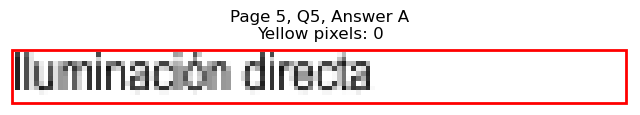

Page 5, Q5 - B: Detected box: x0=68.3, y0=381.4, x1=138.0, y1=392.5
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 349
Page 5, Q5, B: Yellow percentage: 0.0%


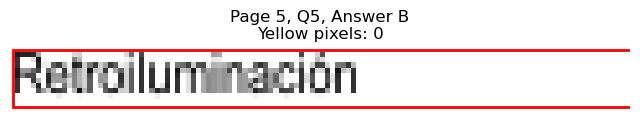

Page 5, Q5 - C: Detected box: x0=327.5, y0=368.8, x1=409.2, y1=379.9
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 565
Page 5, Q5, C: Yellow percentage: 0.0%


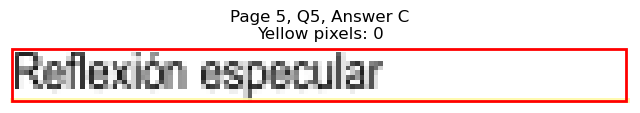

Page 5, Q5 - D: Detected box: x0=327.5, y0=381.4, x1=406.2, y1=392.5
Page 5, Q5, D: Yellow pixels: 1125
Page 5, Q5, D: Total non-white pixels: 1560
Page 5, Q5, D: Yellow percentage: 72.1%


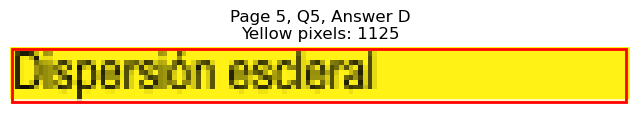


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=432.0, x1=109.0, y1=443.0
Page 5, Q6, A: Yellow pixels: 951
Page 5, Q6, A: Total non-white pixels: 1092
Page 5, Q6, A: Yellow percentage: 87.1%


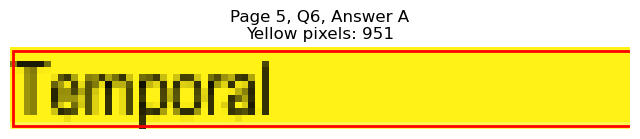

Page 5, Q6 - B: Detected box: x0=68.3, y0=444.6, x1=93.8, y1=455.6
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 132
Page 5, Q6, B: Yellow percentage: 0.0%


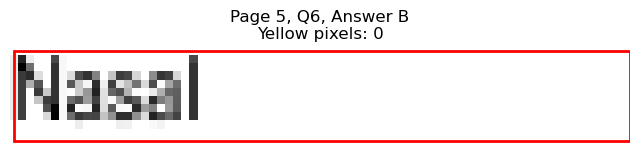

Page 5, Q6 - C: Detected box: x0=327.5, y0=432.0, x1=359.0, y1=443.0
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 151
Page 5, Q6, C: Yellow percentage: 0.0%


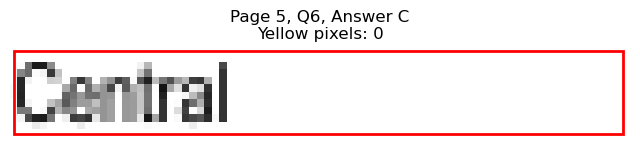

Page 5, Q6 - D: Detected box: x0=327.5, y0=444.6, x1=364.1, y1=455.6
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 162
Page 5, Q6, D: Yellow percentage: 0.0%


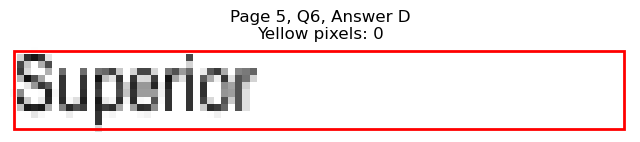


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=495.1, x1=96.8, y1=506.1
Page 5, Q7, A: Yellow pixels: 774
Page 5, Q7, A: Total non-white pixels: 869
Page 5, Q7, A: Yellow percentage: 89.1%


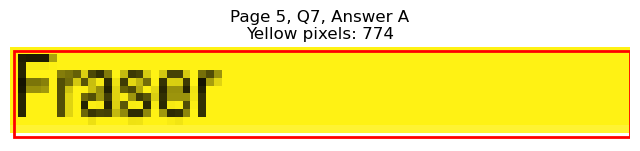

Page 5, Q7 - B: Detected box: x0=68.3, y0=507.7, x1=95.9, y1=518.7
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 141
Page 5, Q7, B: Yellow percentage: 0.0%


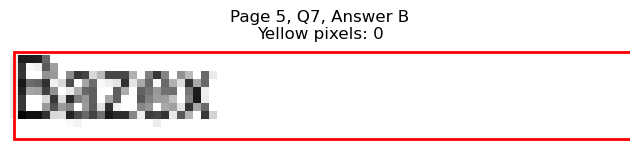

Page 5, Q7 - C: Detected box: x0=327.5, y0=495.1, x1=372.1, y1=506.1
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 212
Page 5, Q7, C: Yellow percentage: 0.0%


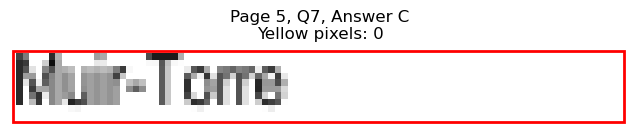

Page 5, Q7 - D: Detected box: x0=327.5, y0=507.7, x1=378.1, y1=518.7
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 244
Page 5, Q7, D: Yellow percentage: 0.0%


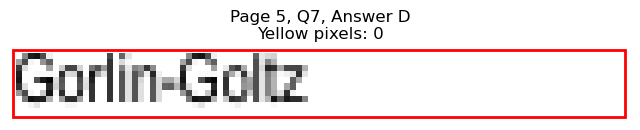


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=545.5, x1=123.5, y1=556.5
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 291
Page 5, Q8, A: Yellow percentage: 0.0%


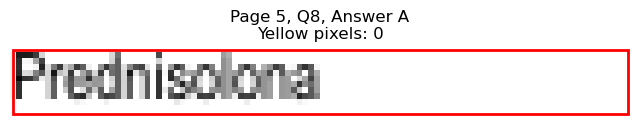

Page 5, Q8 - B: Detected box: x0=68.3, y0=558.2, x1=104.4, y1=569.2
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 181
Page 5, Q8, B: Yellow percentage: 0.0%


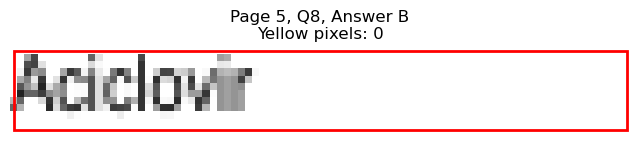

Page 5, Q8 - C: Detected box: x0=327.5, y0=545.5, x1=378.6, y1=556.5
Page 5, Q8, C: Yellow pixels: 924
Page 5, Q8, C: Total non-white pixels: 1224
Page 5, Q8, C: Yellow percentage: 75.5%


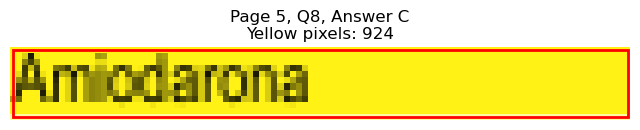

Page 5, Q8 - D: Detected box: x0=327.5, y0=558.2, x1=389.2, y1=569.2
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 331
Page 5, Q8, D: Yellow percentage: 0.0%


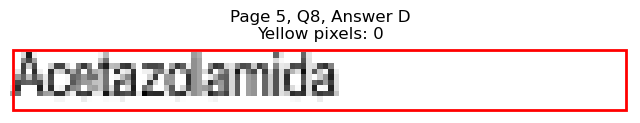


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=596.0, x1=114.5, y1=607.0
Page 5, Q9, A: Yellow pixels: 97
Page 5, Q9, A: Total non-white pixels: 442
Page 5, Q9, A: Yellow percentage: 21.9%


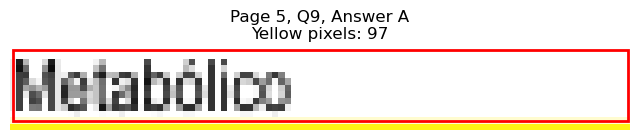

Page 5, Q9 - B: Detected box: x0=68.3, y0=608.6, x1=115.9, y1=619.6
Page 5, Q9, B: Yellow pixels: 999
Page 5, Q9, B: Total non-white pixels: 1176
Page 5, Q9, B: Yellow percentage: 84.9%


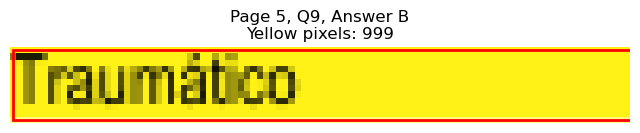

Page 5, Q9 - C: Detected box: x0=327.5, y0=596.0, x1=371.2, y1=607.0
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 233
Page 5, Q9, C: Yellow percentage: 0.0%


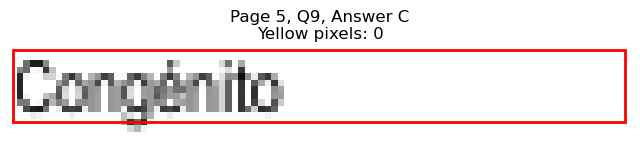

Page 5, Q9 - D: Detected box: x0=327.5, y0=608.6, x1=362.6, y1=619.6
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 173
Page 5, Q9, D: Yellow percentage: 0.0%


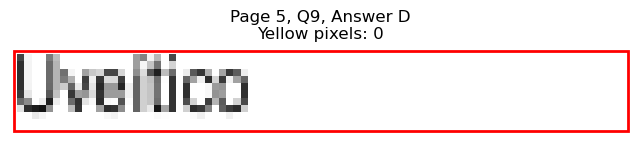


Page 5, Q9 - Selected Answer: B (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=671.7, x1=184.7, y1=682.8
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 532
Page 5, Q10, A: Yellow percentage: 0.0%


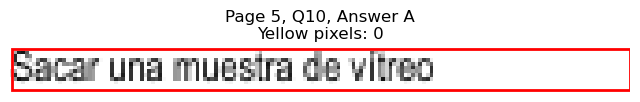

Page 5, Q10 - B: Detected box: x0=68.3, y0=684.3, x1=178.7, y1=695.4
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 533
Page 5, Q10, B: Yellow percentage: 0.0%


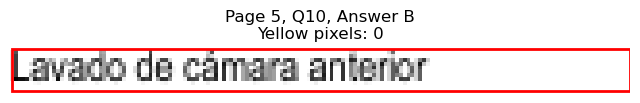

Page 5, Q10 - C: Detected box: x0=327.5, y0=671.7, x1=434.3, y1=682.8
Page 5, Q10, C: Yellow pixels: 158
Page 5, Q10, C: Total non-white pixels: 708
Page 5, Q10, C: Yellow percentage: 22.3%


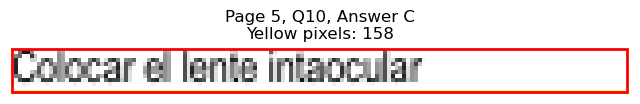

Page 5, Q10 - D: Detected box: x0=327.5, y0=684.3, x1=476.4, y1=695.4
Page 5, Q10, D: Yellow pixels: 1627
Page 5, Q10, D: Total non-white pixels: 2400
Page 5, Q10, D: Yellow percentage: 67.8%


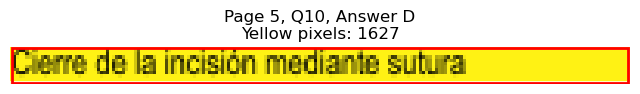


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)




Page 5, Q11 - A: Detected box: x0=68.3, y0=722.2, x1=118.0, y1=733.3
Page 5, Q11, A: Yellow pixels: 0
Page 5, Q11, A: Total non-white pixels: 270
Page 5, Q11, A: Yellow percentage: 0.0%


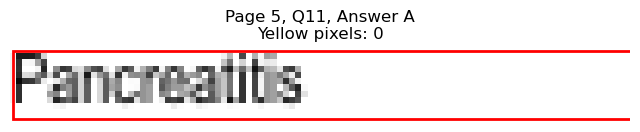

Page 5, Q11 - B: Detected box: x0=68.3, y0=734.8, x1=103.3, y1=745.9
Page 5, Q11, B: Yellow pixels: 0
Page 5, Q11, B: Total non-white pixels: 163
Page 5, Q11, B: Yellow percentage: 0.0%


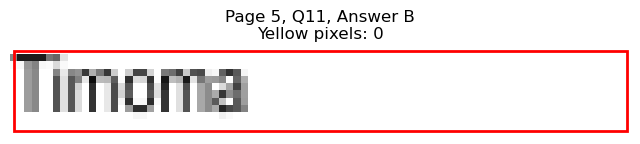

Page 5, Q11 - C: Detected box: x0=327.5, y0=722.2, x1=375.6, y1=733.3
Page 5, Q11, C: Yellow pixels: 99
Page 5, Q11, C: Total non-white pixels: 362
Page 5, Q11, C: Yellow percentage: 27.3%


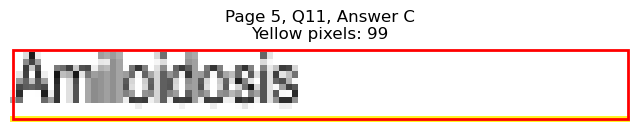

Page 5, Q11 - D: Detected box: x0=327.5, y0=734.8, x1=369.1, y1=745.9
Page 5, Q11, D: Yellow pixels: 978
Page 5, Q11, D: Total non-white pixels: 1116
Page 5, Q11, D: Yellow percentage: 87.6%


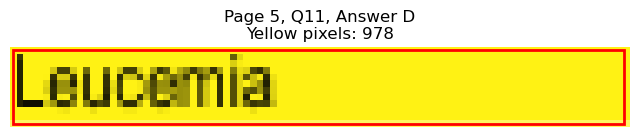


Page 5, Q11 - Selected Answer: D (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=122.4, y1=114.8
Page 6, Q1, A: Yellow pixels: 1042
Page 6, Q1, A: Total non-white pixels: 1260
Page 6, Q1, A: Yellow percentage: 82.7%


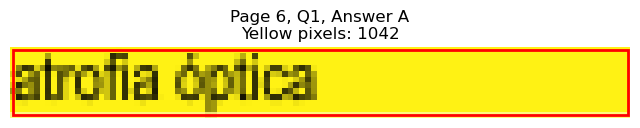

Page 6, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=117.5, y1=127.4
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 255
Page 6, Q1, B: Yellow percentage: 0.0%


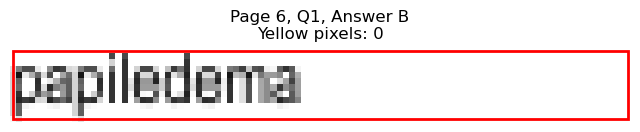

Page 6, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=385.7, y1=114.8
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 277
Page 6, Q1, C: Yellow percentage: 0.0%


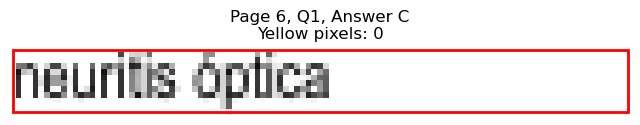

Page 6, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=384.1, y1=127.4
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 278
Page 6, Q1, D: Yellow percentage: 0.0%


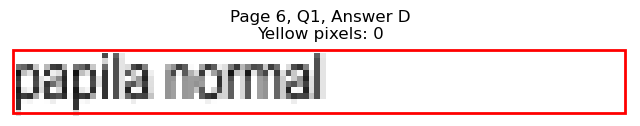


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=246.8, y1=203.1
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 913
Page 6, Q2, A: Yellow percentage: 0.0%


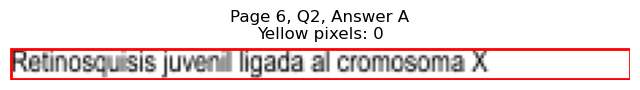

Page 6, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=212.8, y1=215.7
Page 6, Q2, B: Yellow pixels: 1
Page 6, Q2, B: Total non-white pixels: 941
Page 6, Q2, B: Yellow percentage: 0.1%


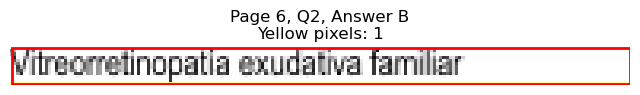

Page 6, Q2 - C: Detected box: x0=68.8, y0=217.4, x1=279.8, y1=228.4
Page 6, Q2, C: Yellow pixels: 2031
Page 6, Q2, C: Total non-white pixels: 3144
Page 6, Q2, C: Yellow percentage: 64.6%


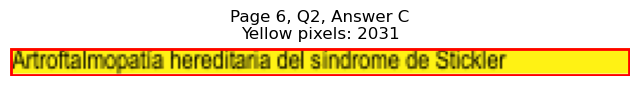

Page 6, Q2 - D: Detected box: x0=68.8, y0=230.0, x1=334.1, y1=241.0
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 1370
Page 6, Q2, D: Yellow percentage: 0.0%


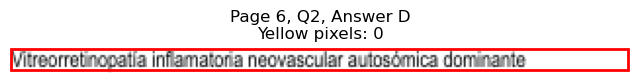


Page 6, Q2 - Selected Answer: C (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=280.5, x1=282.0, y1=291.6
Page 6, Q3, A: Yellow pixels: 264
Page 6, Q3, A: Total non-white pixels: 1344
Page 6, Q3, A: Yellow percentage: 19.6%


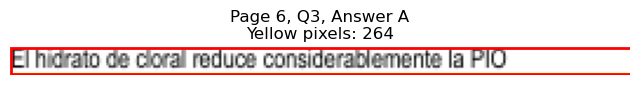

Page 6, Q3 - B: Detected box: x0=68.3, y0=293.1, x1=295.4, y1=304.2
Page 6, Q3, B: Yellow pixels: 2135
Page 6, Q3, B: Total non-white pixels: 3060
Page 6, Q3, B: Yellow percentage: 69.8%


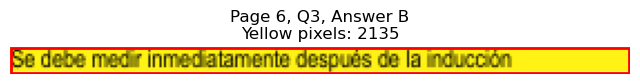

Page 6, Q3 - C: Detected box: x0=68.8, y0=305.7, x1=283.4, y1=316.8
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 1089
Page 6, Q3, C: Yellow percentage: 0.0%


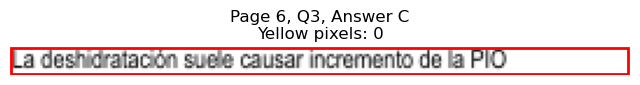

Page 6, Q3 - D: Detected box: x0=68.8, y0=318.3, x1=274.9, y1=329.4
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 1025
Page 6, Q3, D: Yellow percentage: 0.0%


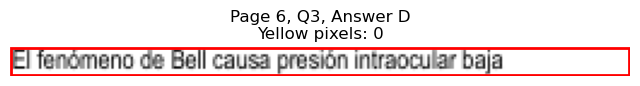


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=356.2, x1=85.2, y1=367.3
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 78
Page 6, Q4, A: Yellow percentage: 0.0%


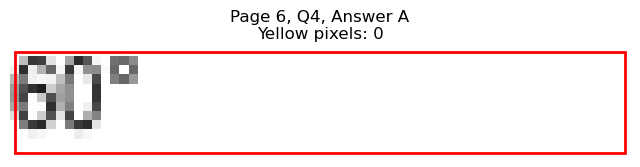

Page 6, Q4 - B: Detected box: x0=68.3, y0=368.8, x1=85.2, y1=379.9
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 66
Page 6, Q4, B: Yellow percentage: 0.0%


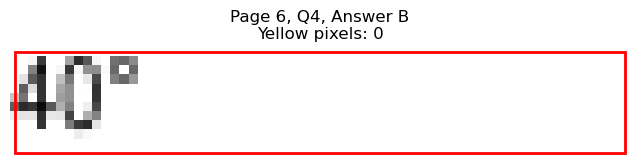

Page 6, Q4 - C: Detected box: x0=327.5, y0=356.2, x1=344.4, y1=367.3
Page 6, Q4, C: Yellow pixels: 700
Page 6, Q4, C: Total non-white pixels: 816
Page 6, Q4, C: Yellow percentage: 85.8%


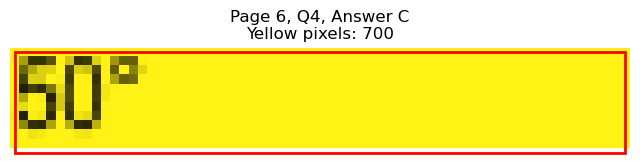

Page 6, Q4 - D: Detected box: x0=327.5, y0=368.8, x1=344.4, y1=379.9
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 70
Page 6, Q4, D: Yellow percentage: 0.0%


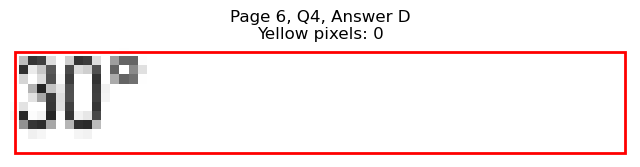


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=204.6, y1=417.7
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 697
Page 6, Q5, A: Yellow percentage: 0.0%


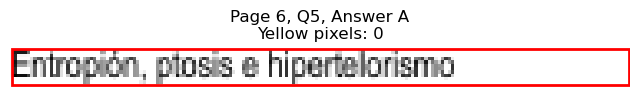

Page 6, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=195.1, y1=430.4
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 666
Page 6, Q5, B: Yellow percentage: 0.0%


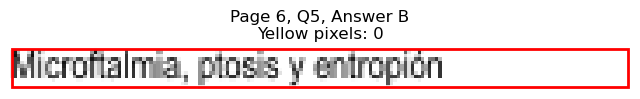

Page 6, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=450.8, y1=417.7
Page 6, Q5, C: Yellow pixels: 174
Page 6, Q5, C: Total non-white pixels: 778
Page 6, Q5, C: Yellow percentage: 22.4%


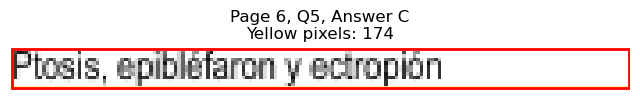

Page 6, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=471.5, y1=430.4
Page 6, Q5, D: Yellow pixels: 1626
Page 6, Q5, D: Total non-white pixels: 2340
Page 6, Q5, D: Yellow percentage: 69.5%


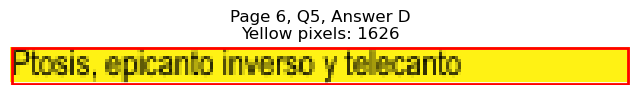


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=210.7, y1=493.5
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 731
Page 6, Q6, A: Yellow percentage: 0.0%


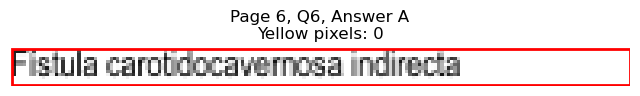

Page 6, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=180.1, y1=506.1
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 561
Page 6, Q6, B: Yellow percentage: 0.0%


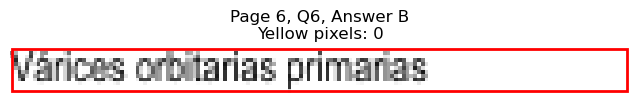

Page 6, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=452.9, y1=493.5
Page 6, Q6, C: Yellow pixels: 176
Page 6, Q6, C: Total non-white pixels: 775
Page 6, Q6, C: Yellow percentage: 22.7%


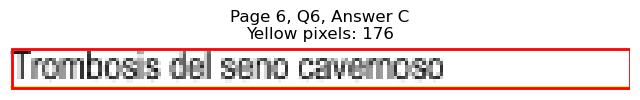

Page 6, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=462.8, y1=506.1
Page 6, Q6, D: Yellow pixels: 1540
Page 6, Q6, D: Total non-white pixels: 2046
Page 6, Q6, D: Yellow percentage: 75.3%


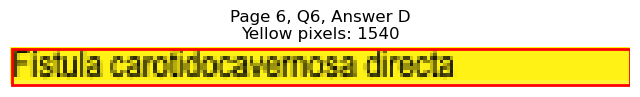


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=152.0, y1=556.5
Page 6, Q7, A: Yellow pixels: 1216
Page 6, Q7, A: Total non-white pixels: 1620
Page 6, Q7, A: Yellow percentage: 75.1%


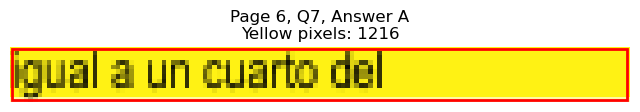

Page 6, Q7 - B: Detected box: x0=68.3, y0=558.2, x1=163.6, y1=569.2
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 459
Page 6, Q7, B: Yellow percentage: 0.0%


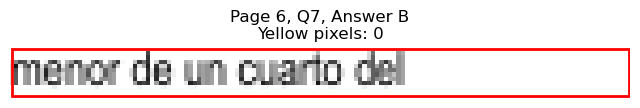

Page 6, Q7 - C: Detected box: x0=327.5, y0=545.5, x1=451.9, y1=556.5
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 571
Page 6, Q7, C: Yellow percentage: 0.0%


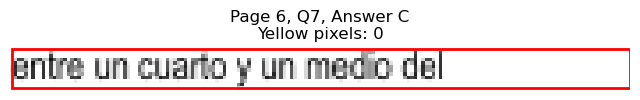

Page 6, Q7 - D: Detected box: x0=327.5, y0=558.2, x1=411.2, y1=569.2
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 382
Page 6, Q7, D: Yellow percentage: 0.0%


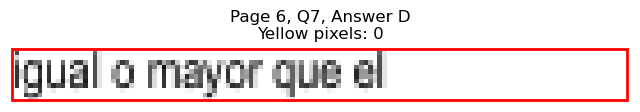


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=596.0, x1=192.7, y1=607.0
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 650
Page 6, Q8, A: Yellow percentage: 0.0%


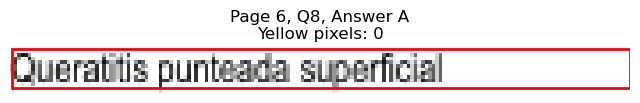

Page 6, Q8 - B: Detected box: x0=68.3, y0=608.6, x1=184.2, y1=619.6
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 606
Page 6, Q8, B: Yellow percentage: 0.0%


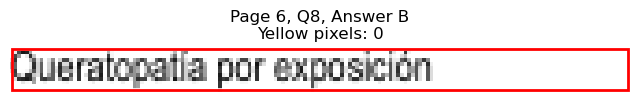

Page 6, Q8 - C: Detected box: x0=327.5, y0=596.0, x1=452.4, y1=607.0
Page 6, Q8, C: Yellow pixels: 1642
Page 6, Q8, C: Total non-white pixels: 2114
Page 6, Q8, C: Yellow percentage: 77.7%


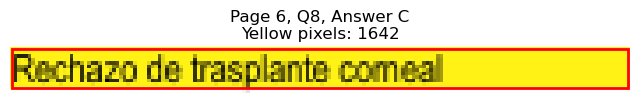

Page 6, Q8 - D: Detected box: x0=327.5, y0=608.6, x1=459.5, y1=619.6
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 731
Page 6, Q8, D: Yellow percentage: 0.0%


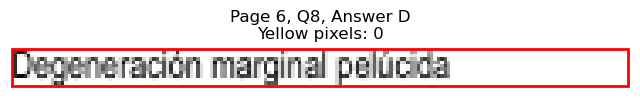


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=684.3, x1=127.0, y1=695.4
Page 6, Q9, A: Yellow pixels: 957
Page 6, Q9, A: Total non-white pixels: 1308
Page 6, Q9, A: Yellow percentage: 73.2%


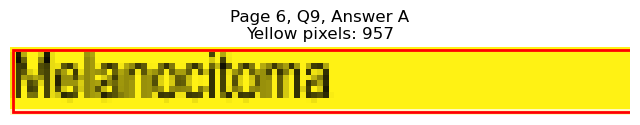

Page 6, Q9 - B: Detected box: x0=68.3, y0=697.0, x1=144.5, y1=708.1
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 395
Page 6, Q9, B: Yellow percentage: 0.0%


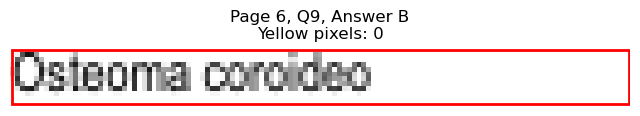

Page 6, Q9 - C: Detected box: x0=327.5, y0=684.3, x1=409.2, y1=695.4
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 414
Page 6, Q9, C: Yellow percentage: 0.0%


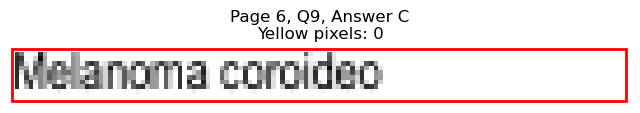

Page 6, Q9 - D: Detected box: x0=327.5, y0=697.0, x1=420.7, y1=708.1
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 461
Page 6, Q9, D: Yellow percentage: 0.0%


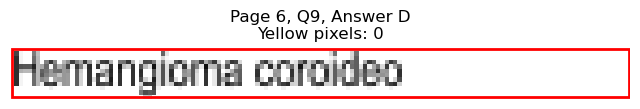


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=734.8, x1=235.3, y1=745.9
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 1039
Page 6, Q10, A: Yellow percentage: 0.0%


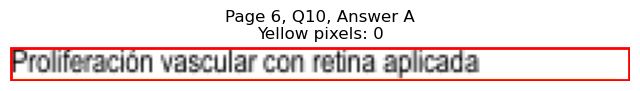

Page 6, Q10 - B: Detected box: x0=68.3, y0=747.4, x1=205.7, y1=758.5
Page 6, Q10, B: Yellow pixels: 1540
Page 6, Q10, B: Total non-white pixels: 2256
Page 6, Q10, B: Yellow percentage: 68.3%


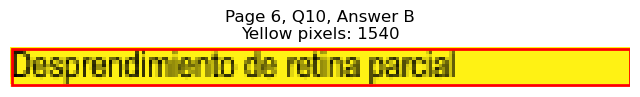

Page 6, Q10 - C: Detected box: x0=327.5, y0=734.8, x1=455.4, y1=745.9
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 650
Page 6, Q10, C: Yellow percentage: 0.0%


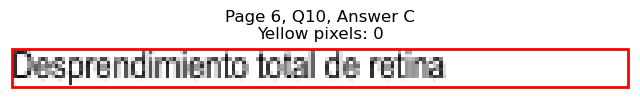

Page 6, Q10 - D: Detected box: x0=327.5, y0=747.4, x1=486.0, y1=758.5
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 803
Page 6, Q10, D: Yellow percentage: 0.0%


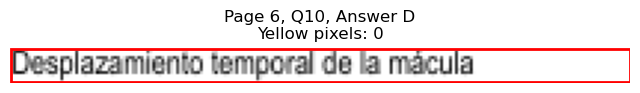


Page 6, Q10 - Selected Answer: B (based on yellow pixel count)





Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=148.6, y1=102.2
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 404
Page 7, Q1, A: Yellow percentage: 0.0%


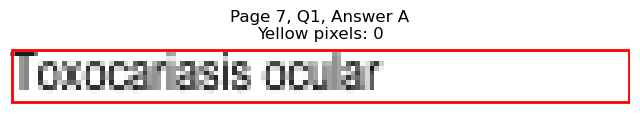

Page 7, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=117.5, y1=114.8
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 264
Page 7, Q1, B: Yellow percentage: 0.0%


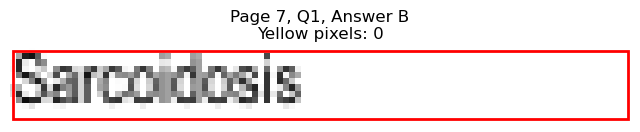

Page 7, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=429.4, y1=102.2
Page 7, Q1, C: Yellow pixels: 1289
Page 7, Q1, C: Total non-white pixels: 1687
Page 7, Q1, C: Yellow percentage: 76.4%


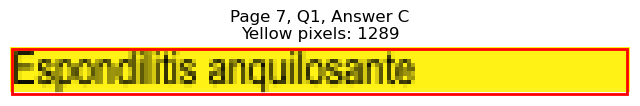

Page 7, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=404.8, y1=114.8
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 407
Page 7, Q1, D: Yellow percentage: 0.0%


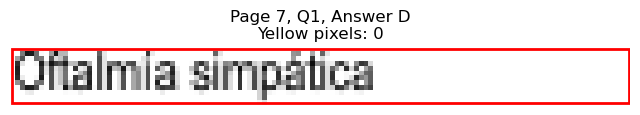


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=141.7, x1=232.8, y1=152.7
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 807
Page 7, Q2, A: Yellow percentage: 0.0%


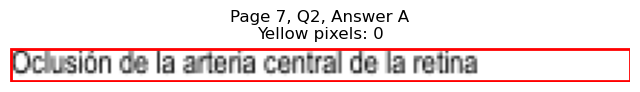

Page 7, Q2 - B: Detected box: x0=68.3, y0=154.3, x1=226.7, y1=165.3
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 767
Page 7, Q2, B: Yellow percentage: 0.0%


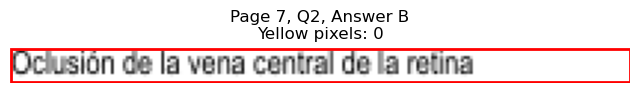

Page 7, Q2 - C: Detected box: x0=327.5, y0=141.7, x1=502.0, y1=152.7
Page 7, Q2, C: Yellow pixels: 213
Page 7, Q2, C: Total non-white pixels: 1109
Page 7, Q2, C: Yellow percentage: 19.2%


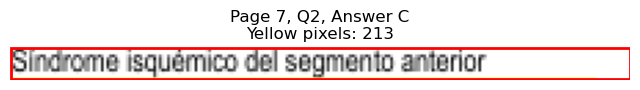

Page 7, Q2 - D: Detected box: x0=327.5, y0=154.3, x1=478.9, y1=165.3
Page 7, Q2, D: Yellow pixels: 1710
Page 7, Q2, D: Total non-white pixels: 2424
Page 7, Q2, D: Yellow percentage: 70.5%


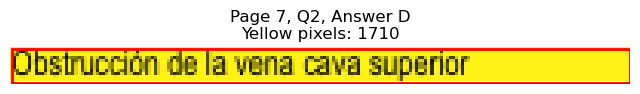


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=204.7, x1=91.8, y1=215.7
Page 7, Q3, A: Yellow pixels: 806
Page 7, Q3, A: Total non-white pixels: 888
Page 7, Q3, A: Yellow percentage: 90.8%


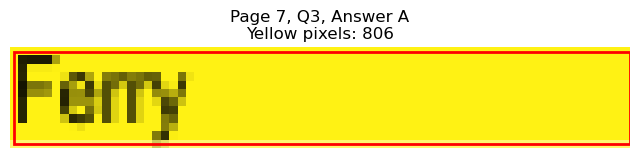

Page 7, Q3 - B: Detected box: x0=68.3, y0=217.4, x1=130.0, y1=228.4
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 296
Page 7, Q3, B: Yellow percentage: 0.0%


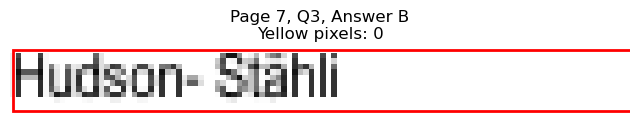

Page 7, Q3 - C: Detected box: x0=327.5, y0=204.7, x1=366.6, y1=215.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 211
Page 7, Q3, C: Yellow percentage: 0.0%


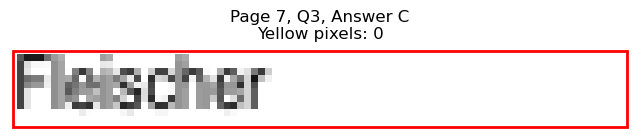

Page 7, Q3 - D: Detected box: x0=327.5, y0=217.4, x1=360.6, y1=228.4
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 168
Page 7, Q3, D: Yellow percentage: 0.0%


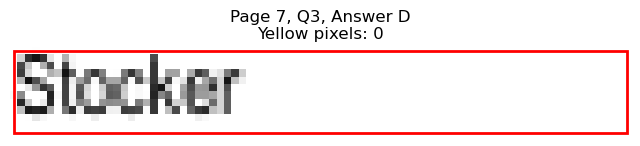


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=267.8, x1=113.4, y1=278.8
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 234
Page 7, Q4, A: Yellow percentage: 0.0%


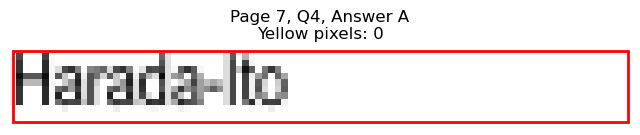

Page 7, Q4 - B: Detected box: x0=68.3, y0=280.5, x1=138.0, y1=291.6
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 340
Page 7, Q4, B: Yellow percentage: 0.0%


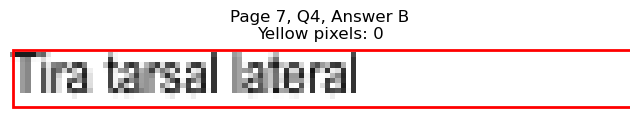

Page 7, Q4 - C: Detected box: x0=327.5, y0=267.8, x1=398.2, y1=278.8
Page 7, Q4, C: Yellow pixels: 1200
Page 7, Q4, C: Total non-white pixels: 1464
Page 7, Q4, C: Yellow percentage: 82.0%


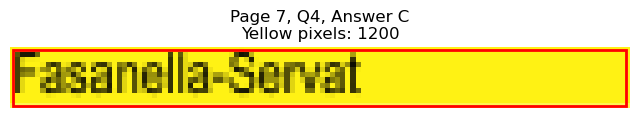

Page 7, Q4 - D: Detected box: x0=327.5, y0=280.5, x1=350.0, y1=291.6
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 119
Page 7, Q4, D: Yellow percentage: 0.0%


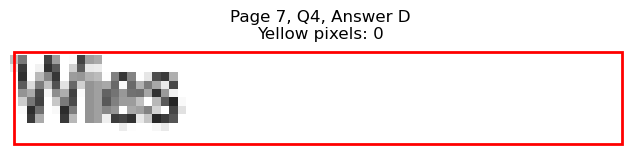


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=330.9, x1=185.6, y1=342.0
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 595
Page 7, Q5, A: Yellow percentage: 0.0%


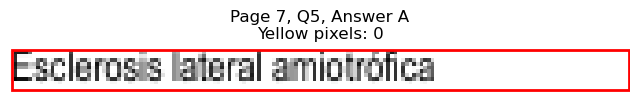

Page 7, Q5 - B: Detected box: x0=68.3, y0=343.6, x1=144.0, y1=354.7
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 403
Page 7, Q5, B: Yellow percentage: 0.0%


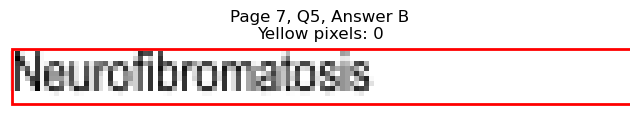

Page 7, Q5 - C: Detected box: x0=327.5, y0=330.9, x1=404.8, y1=342.0
Page 7, Q5, C: Yellow pixels: 1235
Page 7, Q5, C: Total non-white pixels: 1536
Page 7, Q5, C: Yellow percentage: 80.4%


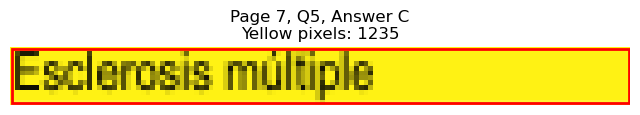

Page 7, Q5 - D: Detected box: x0=327.5, y0=343.6, x1=370.1, y1=354.7
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 208
Page 7, Q5, D: Yellow percentage: 0.0%


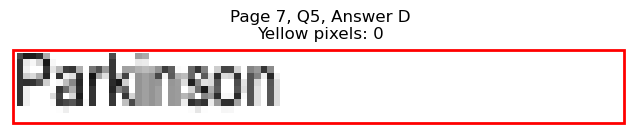


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=394.0, x1=106.4, y1=405.1
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 190
Page 7, Q6, A: Yellow percentage: 0.0%


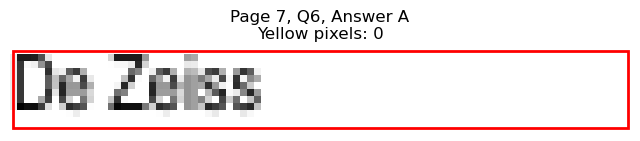

Page 7, Q6 - B: Detected box: x0=68.3, y0=406.6, x1=101.4, y1=417.7
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 178
Page 7, Q6, B: Yellow percentage: 0.0%


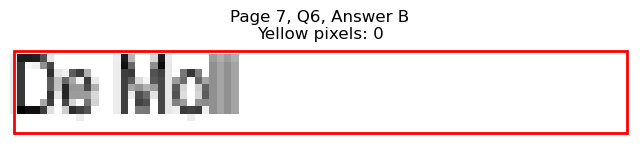

Page 7, Q6 - C: Detected box: x0=327.5, y0=394.0, x1=365.6, y1=405.1
Page 7, Q6, C: Yellow pixels: 836
Page 7, Q6, C: Total non-white pixels: 981
Page 7, Q6, C: Yellow percentage: 85.2%


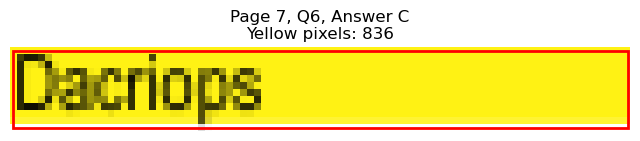

Page 7, Q6 - D: Detected box: x0=327.5, y0=406.6, x1=409.7, y1=417.7
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 421
Page 7, Q6, D: Yellow percentage: 0.0%


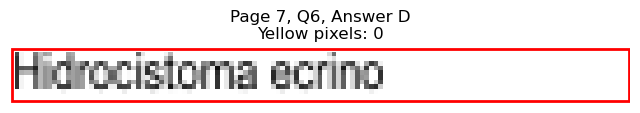


Page 7, Q6 - Selected Answer: C (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=444.6, x1=147.5, y1=455.6
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 439
Page 7, Q7, A: Yellow percentage: 0.0%


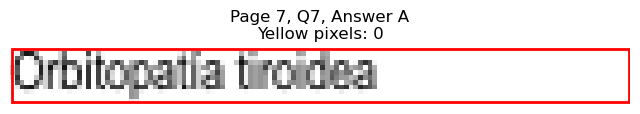

Page 7, Q7 - B: Detected box: x0=68.3, y0=457.2, x1=138.0, y1=468.2
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 345
Page 7, Q7, B: Yellow percentage: 0.0%


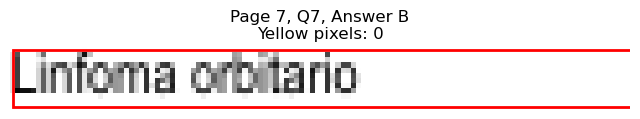

Page 7, Q7 - C: Detected box: x0=327.5, y0=444.6, x1=387.1, y1=455.6
Page 7, Q7, C: Yellow pixels: 993
Page 7, Q7, C: Total non-white pixels: 1332
Page 7, Q7, C: Yellow percentage: 74.5%


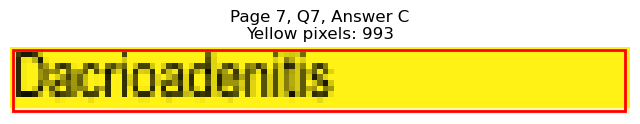

Page 7, Q7 - D: Detected box: x0=327.5, y0=457.2, x1=414.2, y1=468.2
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 440
Page 7, Q7, D: Yellow percentage: 0.0%


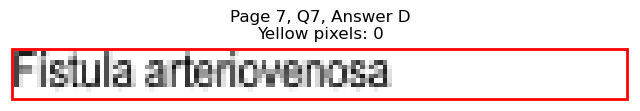


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=520.3, x1=126.5, y1=531.3
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 305
Page 7, Q8, A: Yellow percentage: 0.0%


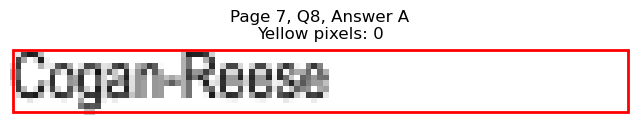

Page 7, Q8 - B: Detected box: x0=68.3, y0=532.9, x1=127.0, y1=543.9
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 302
Page 7, Q8, B: Yellow percentage: 0.0%


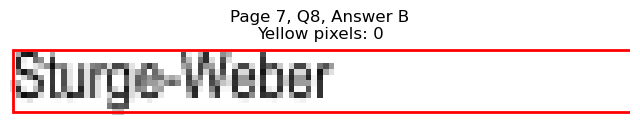

Page 7, Q8 - C: Detected box: x0=327.5, y0=520.3, x1=394.7, y1=531.3
Page 7, Q8, C: Yellow pixels: 1011
Page 7, Q8, C: Total non-white pixels: 1416
Page 7, Q8, C: Yellow percentage: 71.4%


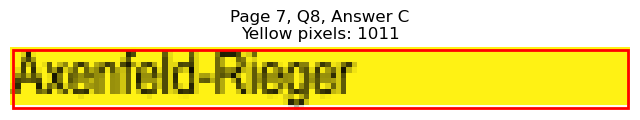

Page 7, Q8 - D: Detected box: x0=327.5, y0=532.9, x1=366.6, y1=543.9
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 211
Page 7, Q8, D: Yellow percentage: 0.0%


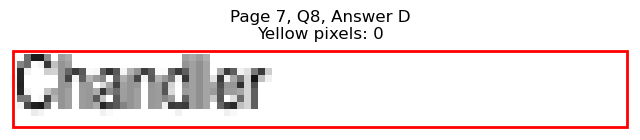


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=570.8, x1=96.8, y1=581.8
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 155
Page 7, Q9, A: Yellow percentage: 0.0%


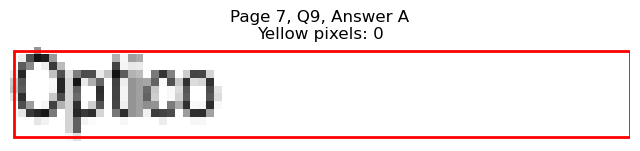

Page 7, Q9 - B: Detected box: x0=68.3, y0=583.4, x1=117.5, y1=594.4
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 251
Page 7, Q9, B: Yellow percentage: 0.0%


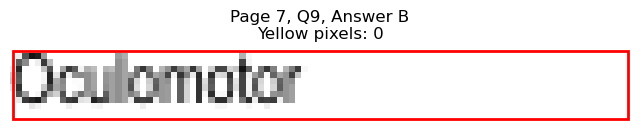

Page 7, Q9 - C: Detected box: x0=327.5, y0=570.8, x1=354.1, y1=581.8
Page 7, Q9, C: Yellow pixels: 840
Page 7, Q9, C: Total non-white pixels: 936
Page 7, Q9, C: Yellow percentage: 89.7%


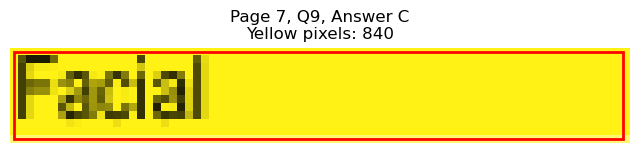

Page 7, Q9 - D: Detected box: x0=327.5, y0=583.4, x1=370.1, y1=594.4
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 213
Page 7, Q9, D: Yellow percentage: 0.0%


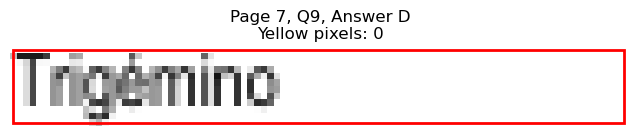


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=646.5, x1=203.6, y1=657.6
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 652
Page 7, Q10, A: Yellow percentage: 0.0%


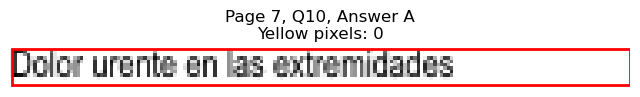

Page 7, Q10 - B: Detected box: x0=68.3, y0=659.1, x1=173.0, y1=670.2
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 540
Page 7, Q10, B: Yellow percentage: 0.0%


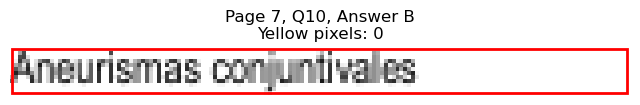

Page 7, Q10 - C: Detected box: x0=327.5, y0=646.5, x1=425.8, y1=657.6
Page 7, Q10, C: Yellow pixels: 1284
Page 7, Q10, C: Total non-white pixels: 1788
Page 7, Q10, C: Yellow percentage: 71.8%


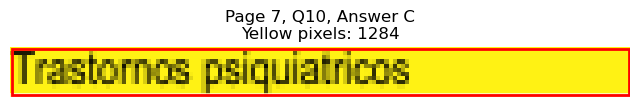

Page 7, Q10 - D: Detected box: x0=327.5, y0=659.1, x1=412.7, y1=670.2
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 465
Page 7, Q10, D: Yellow percentage: 0.0%


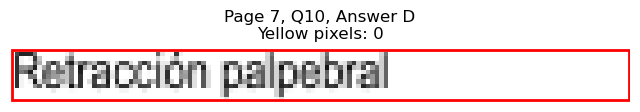


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=68.3, y0=734.8, x1=146.5, y1=745.9
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 406
Page 7, Q11, A: Yellow percentage: 0.0%


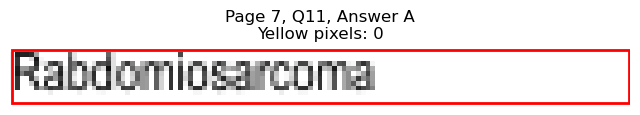

Page 7, Q11 - B: Detected box: x0=68.3, y0=747.4, x1=154.6, y1=758.5
Page 7, Q11, B: Yellow pixels: 0
Page 7, Q11, B: Total non-white pixels: 474
Page 7, Q11, B: Yellow percentage: 0.0%


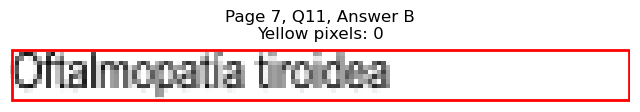

Page 7, Q11 - C: Detected box: x0=327.5, y0=734.8, x1=418.8, y1=745.9
Page 7, Q11, C: Yellow pixels: 0
Page 7, Q11, C: Total non-white pixels: 606
Page 7, Q11, C: Yellow percentage: 0.0%


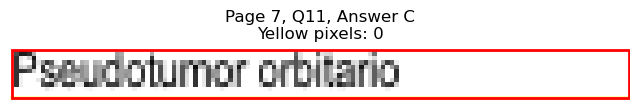

Page 7, Q11 - D: Detected box: x0=327.5, y0=747.4, x1=385.1, y1=758.5
Page 7, Q11, D: Yellow pixels: 964
Page 7, Q11, D: Total non-white pixels: 1308
Page 7, Q11, D: Yellow percentage: 73.7%


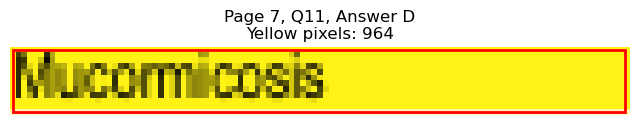


Page 7, Q11 - Selected Answer: D (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=173.5, y1=102.2
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 537
Page 8, Q1, A: Yellow percentage: 0.0%


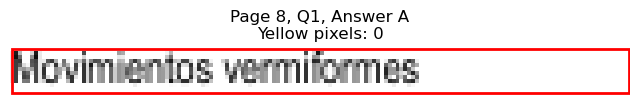

Page 8, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=237.7, y1=114.8
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 814
Page 8, Q1, B: Yellow percentage: 0.0%


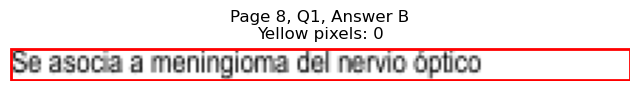

Page 8, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=463.9, y1=102.2
Page 8, Q1, C: Yellow pixels: 1559
Page 8, Q1, C: Total non-white pixels: 2058
Page 8, Q1, C: Yellow percentage: 75.8%


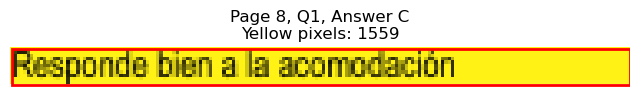

Page 8, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=476.9, y1=114.8
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 788
Page 8, Q1, D: Yellow percentage: 0.0%


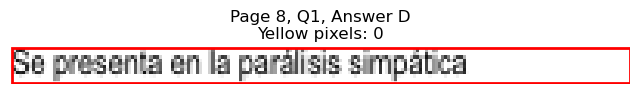


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=141.7, x1=158.5, y1=152.7
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 420
Page 8, Q2, A: Yellow percentage: 0.0%


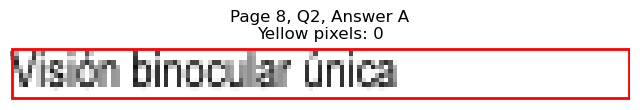

Page 8, Q2 - B: Detected box: x0=68.3, y0=154.3, x1=162.6, y1=165.3
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 470
Page 8, Q2, B: Yellow percentage: 0.0%


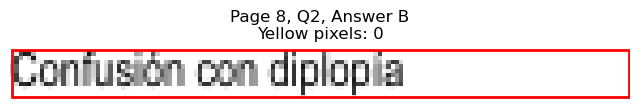

Page 8, Q2 - C: Detected box: x0=327.5, y0=141.7, x1=472.9, y1=152.7
Page 8, Q2, C: Yellow pixels: 1816
Page 8, Q2, C: Total non-white pixels: 2352
Page 8, Q2, C: Yellow percentage: 77.2%


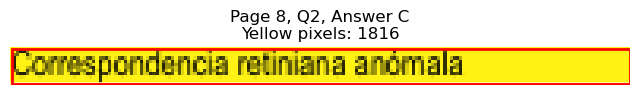

Page 8, Q2 - D: Detected box: x0=327.5, y0=154.3, x1=465.8, y1=165.3
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 686
Page 8, Q2, D: Yellow percentage: 0.0%


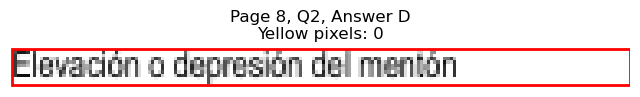


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=192.1, x1=375.2, y1=203.1
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 1499
Page 8, Q3, A: Yellow percentage: 0.0%


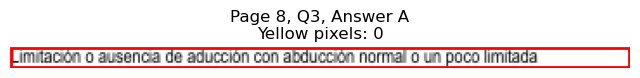

Page 8, Q3 - B: Detected box: x0=68.3, y0=204.7, x1=310.0, y1=215.7
Page 8, Q3, B: Yellow pixels: 2
Page 8, Q3, B: Total non-white pixels: 1454
Page 8, Q3, B: Yellow percentage: 0.1%


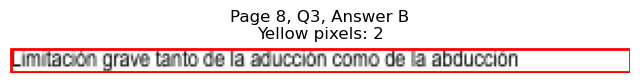

Page 8, Q3 - C: Detected box: x0=68.8, y0=217.4, x1=398.3, y1=228.4
Page 8, Q3, C: Yellow pixels: 3005
Page 8, Q3, C: Total non-white pixels: 4572
Page 8, Q3, C: Yellow percentage: 65.7%


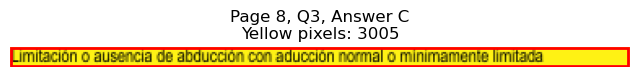

Page 8, Q3 - D: Detected box: x0=68.8, y0=230.0, x1=352.7, y1=241.0
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 1413
Page 8, Q3, D: Yellow percentage: 0.0%


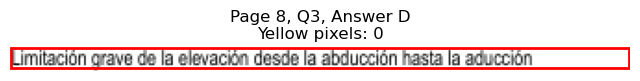


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=267.8, x1=110.9, y1=278.8
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 226
Page 8, Q4, A: Yellow percentage: 0.0%


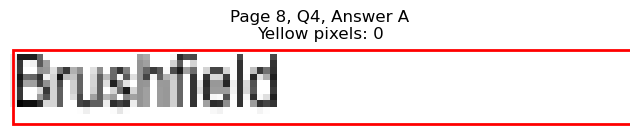

Page 8, Q4 - B: Detected box: x0=68.3, y0=280.5, x1=104.9, y1=291.6
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 176
Page 8, Q4, B: Yellow percentage: 0.0%


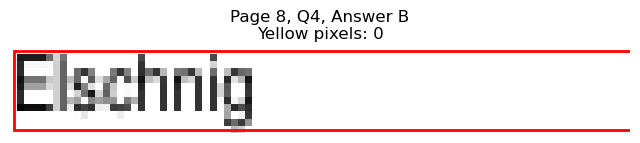

Page 8, Q4 - C: Detected box: x0=327.5, y0=267.8, x1=354.6, y1=278.8
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 221
Page 8, Q4, C: Yellow percentage: 0.0%


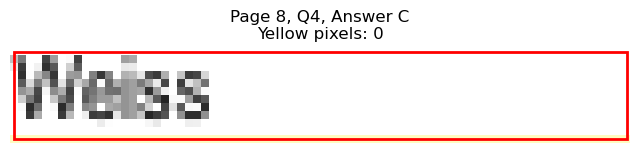

Page 8, Q4 - D: Detected box: x0=327.5, y0=280.5, x1=351.1, y1=291.6
Page 8, Q4, D: Yellow pixels: 751
Page 8, Q4, D: Total non-white pixels: 900
Page 8, Q4, D: Yellow percentage: 83.4%


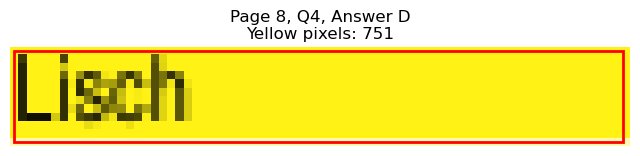


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=330.9, x1=124.0, y1=342.0
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 381
Page 8, Q5, A: Yellow percentage: 0.0%


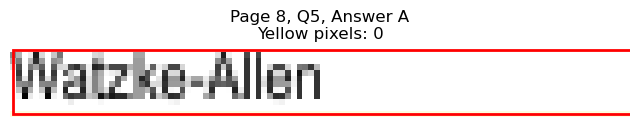

Page 8, Q5 - B: Detected box: x0=68.3, y0=343.6, x1=127.0, y1=354.7
Page 8, Q5, B: Yellow pixels: 1083
Page 8, Q5, B: Total non-white pixels: 1308
Page 8, Q5, B: Yellow percentage: 82.8%


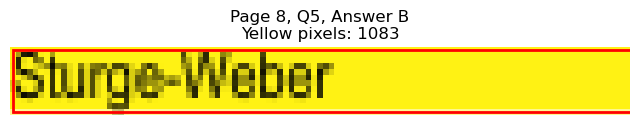

Page 8, Q5 - C: Detected box: x0=327.5, y0=330.9, x1=410.8, y1=342.0
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 429
Page 8, Q5, C: Yellow percentage: 0.0%


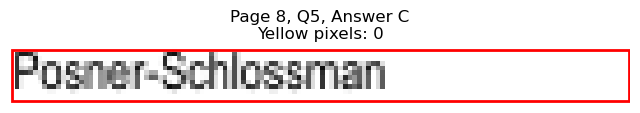

Page 8, Q5 - D: Detected box: x0=327.5, y0=343.6, x1=379.1, y1=354.7
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 250
Page 8, Q5, D: Yellow percentage: 0.0%


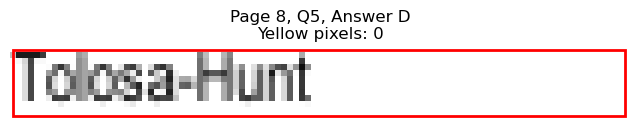


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=432.0, x1=292.0, y1=443.0
Page 8, Q6, A: Yellow pixels: 2436
Page 8, Q6, A: Total non-white pixels: 3288
Page 8, Q6, A: Yellow percentage: 74.1%


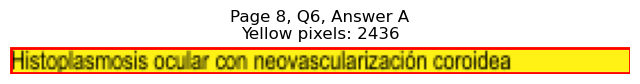

Page 8, Q6 - B: Detected box: x0=68.3, y0=444.6, x1=236.9, y1=455.6
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 872
Page 8, Q6, B: Yellow percentage: 0.0%


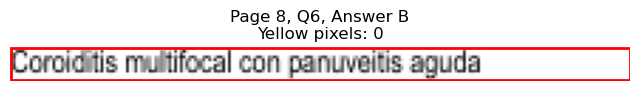

Page 8, Q6 - C: Detected box: x0=68.8, y0=457.2, x1=321.1, y1=468.2
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 1245
Page 8, Q6, C: Yellow percentage: 0.0%


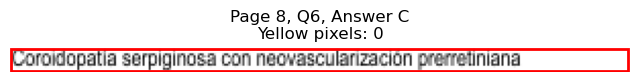

Page 8, Q6 - D: Detected box: x0=68.8, y0=469.8, x1=280.0, y1=480.8
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 1036
Page 8, Q6, D: Yellow percentage: 0.0%


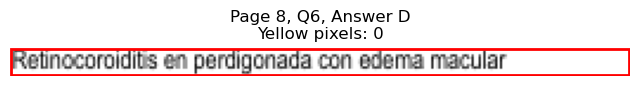


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=507.7, x1=135.5, y1=518.7
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 355
Page 8, Q7, A: Yellow percentage: 0.0%


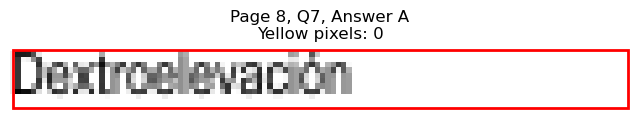

Page 8, Q7 - B: Detected box: x0=68.3, y0=520.3, x1=128.5, y1=531.3
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 308
Page 8, Q7, B: Yellow percentage: 0.0%


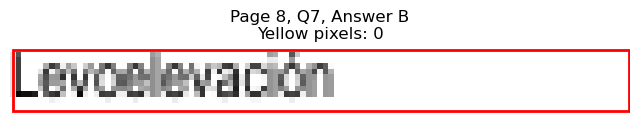

Page 8, Q7 - C: Detected box: x0=327.5, y0=507.7, x1=389.2, y1=518.7
Page 8, Q7, C: Yellow pixels: 113
Page 8, Q7, C: Total non-white pixels: 430
Page 8, Q7, C: Yellow percentage: 26.3%


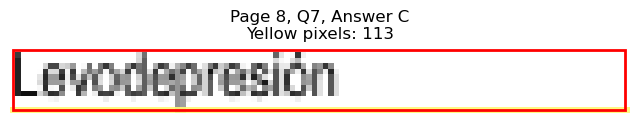

Page 8, Q7 - D: Detected box: x0=327.5, y0=520.3, x1=396.2, y1=531.3
Page 8, Q7, D: Yellow pixels: 1047
Page 8, Q7, D: Total non-white pixels: 1440
Page 8, Q7, D: Yellow percentage: 72.7%


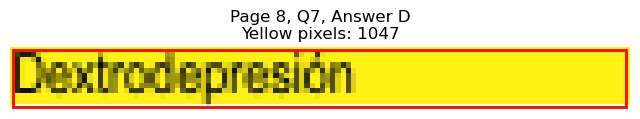


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=570.8, x1=154.6, y1=581.8
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 440
Page 8, Q8, A: Yellow percentage: 0.0%


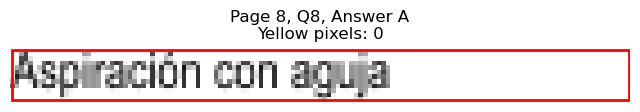

Page 8, Q8 - B: Detected box: x0=68.3, y0=583.4, x1=127.0, y1=594.4
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 288
Page 8, Q8, B: Yellow percentage: 0.0%


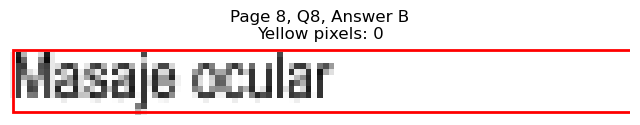

Page 8, Q8 - C: Detected box: x0=327.5, y0=570.8, x1=380.6, y1=581.8
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 371
Page 8, Q8, C: Yellow percentage: 0.0%


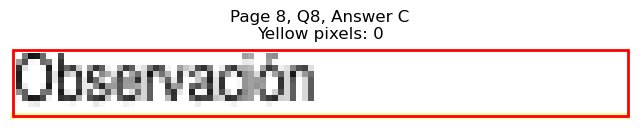

Page 8, Q8 - D: Detected box: x0=327.5, y0=583.4, x1=418.2, y1=594.4
Page 8, Q8, D: Yellow pixels: 1216
Page 8, Q8, D: Total non-white pixels: 1704
Page 8, Q8, D: Yellow percentage: 71.4%


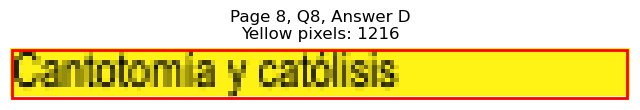


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=671.7, x1=250.3, y1=682.8
Page 8, Q9, A: Yellow pixels: 2081
Page 8, Q9, A: Total non-white pixels: 2796
Page 8, Q9, A: Yellow percentage: 74.4%


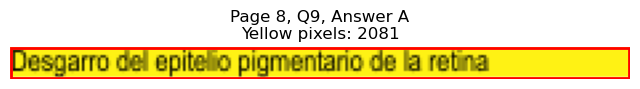

Page 8, Q9 - B: Detected box: x0=68.3, y0=684.3, x1=286.9, y1=695.4
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 1167
Page 8, Q9, B: Yellow percentage: 0.0%


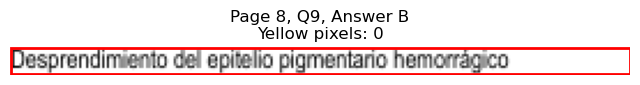

Page 8, Q9 - C: Detected box: x0=68.8, y0=697.0, x1=183.1, y1=708.1
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 605
Page 8, Q9, C: Yellow percentage: 0.0%


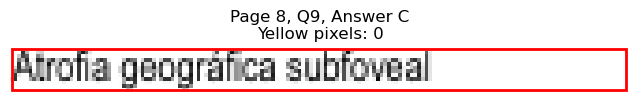

Page 8, Q9 - D: Detected box: x0=68.8, y0=709.6, x1=207.7, y1=720.7
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 714
Page 8, Q9, D: Yellow percentage: 0.0%


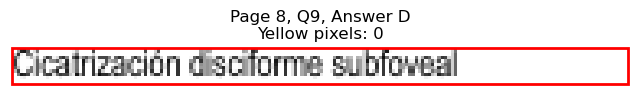


Page 8, Q9 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=181.1, y1=140.0
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 553
Page 9, Q1, A: Yellow percentage: 0.0%


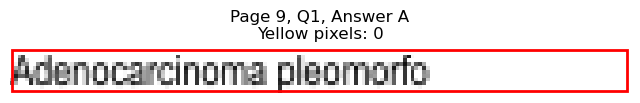

Page 9, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=188.6, y1=152.7
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 594
Page 9, Q1, B: Yellow percentage: 0.0%


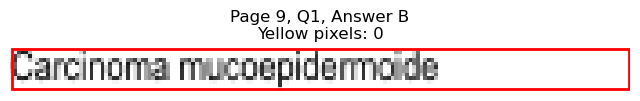

Page 9, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=425.8, y1=140.0
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 638
Page 9, Q1, C: Yellow percentage: 0.0%


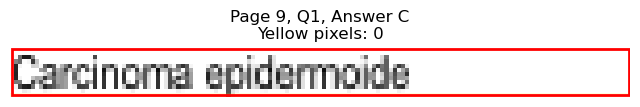

Page 9, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=451.9, y1=152.7
Page 9, Q1, D: Yellow pixels: 1636
Page 9, Q1, D: Total non-white pixels: 2100
Page 9, Q1, D: Yellow percentage: 77.9%


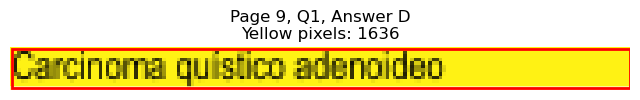


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=107.4, y1=190.5
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 203
Page 9, Q2, A: Yellow percentage: 0.0%


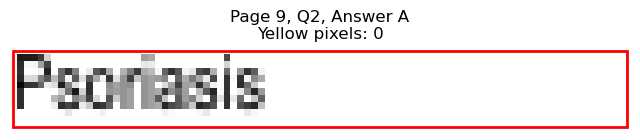

Page 9, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=95.4, y1=203.1
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 119
Page 9, Q2, B: Yellow percentage: 0.0%


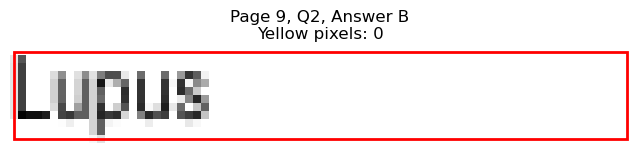

Page 9, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=380.2, y1=190.5
Page 9, Q2, C: Yellow pixels: 951
Page 9, Q2, C: Total non-white pixels: 1248
Page 9, Q2, C: Yellow percentage: 76.2%


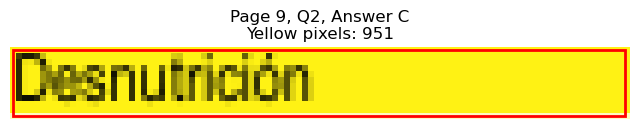

Page 9, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=381.1, y1=203.1
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 306
Page 9, Q2, D: Yellow percentage: 0.0%


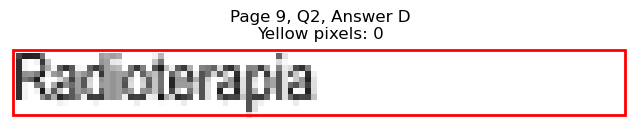


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=85.2, y1=241.0
Page 9, Q3, A: Yellow pixels: 68
Page 9, Q3, A: Total non-white pixels: 204
Page 9, Q3, A: Yellow percentage: 33.3%


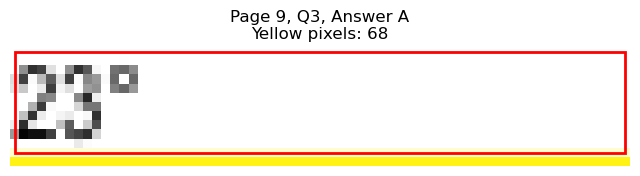

Page 9, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=85.2, y1=253.6
Page 9, Q3, B: Yellow pixels: 702
Page 9, Q3, B: Total non-white pixels: 816
Page 9, Q3, B: Yellow percentage: 86.0%


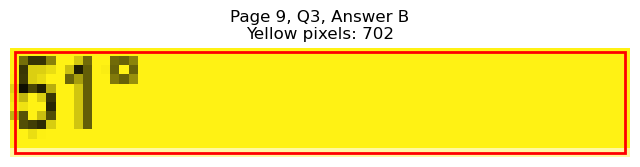

Page 9, Q3 - C: Detected box: x0=327.5, y0=230.0, x1=344.4, y1=241.0
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 74
Page 9, Q3, C: Yellow percentage: 0.0%


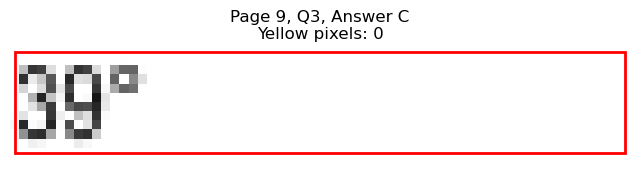

Page 9, Q3 - D: Detected box: x0=327.5, y0=242.6, x1=344.4, y1=253.6
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 68
Page 9, Q3, D: Yellow percentage: 0.0%


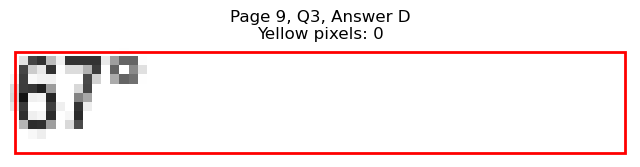


Page 9, Q3 - Selected Answer: B (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=280.5, x1=206.2, y1=291.6
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 690
Page 9, Q4, A: Yellow percentage: 0.0%


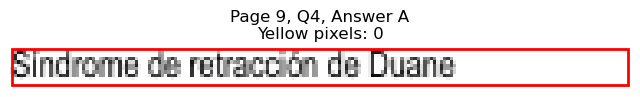

Page 9, Q4 - B: Detected box: x0=68.3, y0=293.1, x1=224.3, y1=304.2
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 787
Page 9, Q4, B: Yellow percentage: 0.0%


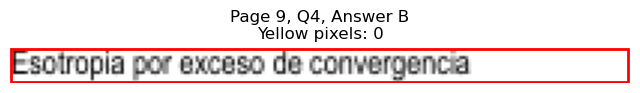

Page 9, Q4 - C: Detected box: x0=327.5, y0=280.5, x1=488.4, y1=291.6
Page 9, Q4, C: Yellow pixels: 212
Page 9, Q4, C: Total non-white pixels: 1024
Page 9, Q4, C: Yellow percentage: 20.7%


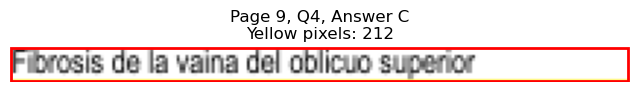

Page 9, Q4 - D: Detected box: x0=327.5, y0=293.1, x1=445.8, y1=304.2
Page 9, Q4, D: Yellow pixels: 1401
Page 9, Q4, D: Total non-white pixels: 1859
Page 9, Q4, D: Yellow percentage: 75.4%


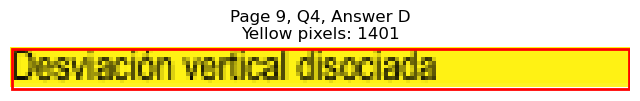


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=330.9, x1=163.1, y1=342.0
Page 9, Q5, A: Yellow pixels: 1423
Page 9, Q5, A: Total non-white pixels: 1752
Page 9, Q5, A: Yellow percentage: 81.2%


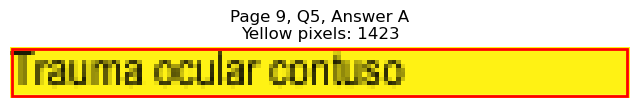

Page 9, Q5 - B: Detected box: x0=68.3, y0=343.6, x1=154.6, y1=354.7
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 439
Page 9, Q5, B: Yellow percentage: 0.0%


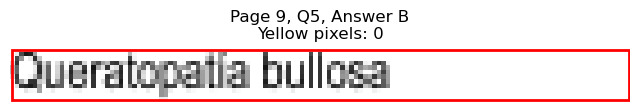

Page 9, Q5 - C: Detected box: x0=327.5, y0=330.9, x1=398.8, y1=342.0
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 356
Page 9, Q5, C: Yellow percentage: 0.0%


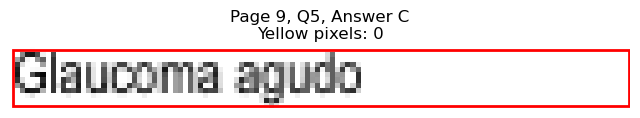

Page 9, Q5 - D: Detected box: x0=327.5, y0=343.6, x1=447.4, y1=354.7
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 632
Page 9, Q5, D: Yellow percentage: 0.0%


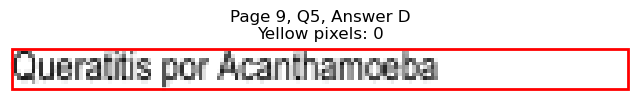


Page 9, Q5 - Selected Answer: A (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=381.4, x1=118.4, y1=392.5
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 257
Page 9, Q6, A: Yellow percentage: 0.0%


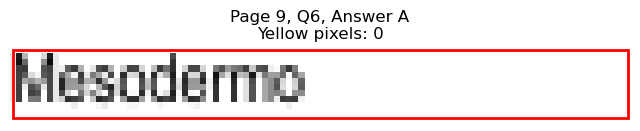

Page 9, Q6 - B: Detected box: x0=68.3, y0=394.0, x1=138.0, y1=405.1
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 367
Page 9, Q6, B: Yellow percentage: 0.0%


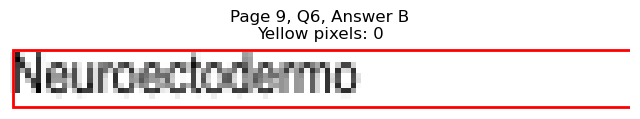

Page 9, Q6 - C: Detected box: x0=327.5, y0=381.4, x1=384.1, y1=392.5
Page 9, Q6, C: Yellow pixels: 981
Page 9, Q6, C: Total non-white pixels: 1296
Page 9, Q6, C: Yellow percentage: 75.7%


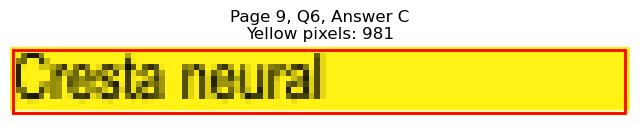

Page 9, Q6 - D: Detected box: x0=327.5, y0=394.0, x1=416.8, y1=405.1
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 460
Page 9, Q6, D: Yellow percentage: 0.0%


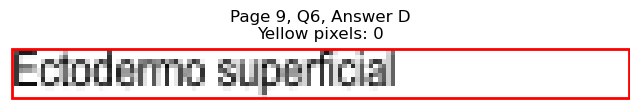


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=469.8, x1=118.4, y1=480.8
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 257
Page 9, Q7, A: Yellow percentage: 0.0%


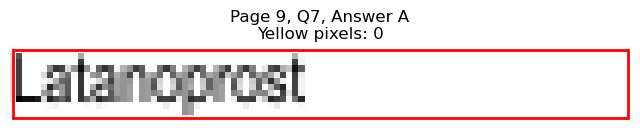

Page 9, Q7 - B: Detected box: x0=68.3, y0=482.5, x1=99.8, y1=493.5
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 144
Page 9, Q7, B: Yellow percentage: 0.0%


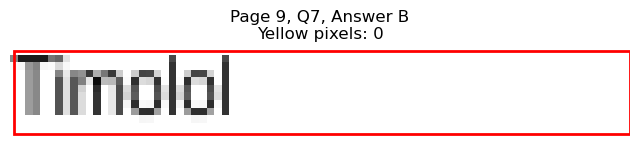

Page 9, Q7 - C: Detected box: x0=327.5, y0=469.8, x1=377.6, y1=480.8
Page 9, Q7, C: Yellow pixels: 1015
Page 9, Q7, C: Total non-white pixels: 1212
Page 9, Q7, C: Yellow percentage: 83.7%


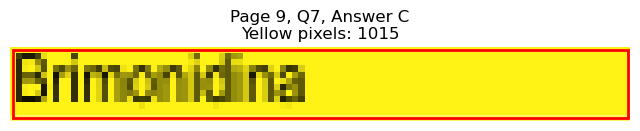

Page 9, Q7 - D: Detected box: x0=327.5, y0=482.5, x1=380.6, y1=493.5
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 271
Page 9, Q7, D: Yellow percentage: 0.0%


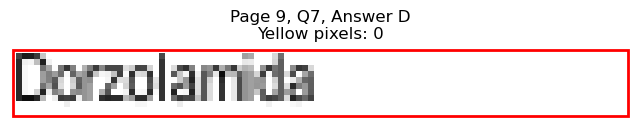


Page 9, Q7 - Selected Answer: C (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=532.9, x1=205.7, y1=543.9
Page 9, Q8, A: Yellow pixels: 1
Page 9, Q8, A: Total non-white pixels: 898
Page 9, Q8, A: Yellow percentage: 0.1%


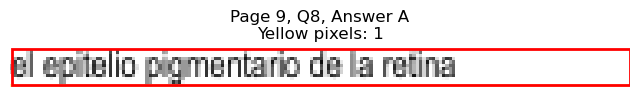

Page 9, Q8 - B: Detected box: x0=68.3, y0=545.5, x1=198.6, y1=556.5
Page 9, Q8, B: Yellow pixels: 1449
Page 9, Q8, B: Total non-white pixels: 2172
Page 9, Q8, B: Yellow percentage: 66.7%


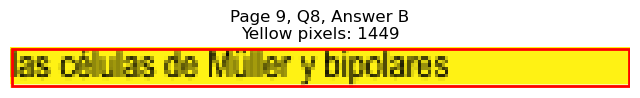

Page 9, Q8 - C: Detected box: x0=327.5, y0=532.9, x1=423.4, y1=543.9
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 497
Page 9, Q8, C: Yellow percentage: 0.0%


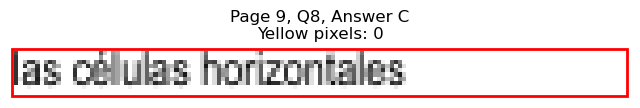

Page 9, Q8 - D: Detected box: x0=327.5, y0=545.5, x1=426.2, y1=556.5
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 532
Page 9, Q8, D: Yellow percentage: 0.0%


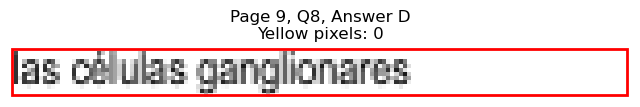


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=214.7, y1=619.6
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 739
Page 9, Q9, A: Yellow percentage: 0.0%


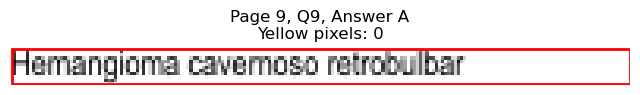

Page 9, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=181.6, y1=632.4
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 580
Page 9, Q9, B: Yellow percentage: 0.0%


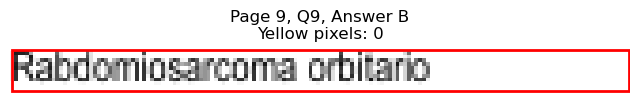

Page 9, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=493.6, y1=619.6
Page 9, Q9, C: Yellow pixels: 1908
Page 9, Q9, C: Total non-white pixels: 2556
Page 9, Q9, C: Yellow percentage: 74.6%


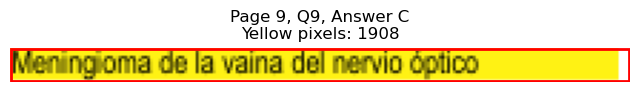

Page 9, Q9 - D: Detected box: x0=327.5, y0=621.3, x1=454.4, y1=632.4
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 652
Page 9, Q9, D: Yellow percentage: 0.0%


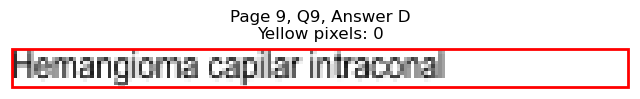


Page 9, Q9 - Selected Answer: C (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=697.0, x1=197.2, y1=708.1
Page 9, Q10, A: Yellow pixels: 180
Page 9, Q10, A: Total non-white pixels: 993
Page 9, Q10, A: Yellow percentage: 18.1%


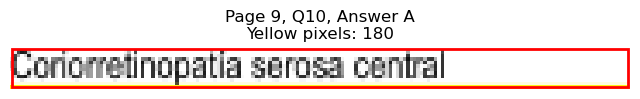

Page 9, Q10 - B: Detected box: x0=68.3, y0=709.6, x1=127.9, y1=720.7
Page 9, Q10, B: Yellow pixels: 1110
Page 9, Q10, B: Total non-white pixels: 1320
Page 9, Q10, B: Yellow percentage: 84.1%


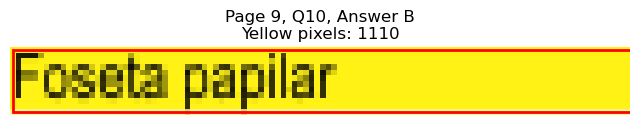

Page 9, Q10 - C: Detected box: x0=327.5, y0=697.0, x1=420.7, y1=708.1
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 494
Page 9, Q10, C: Yellow percentage: 0.0%


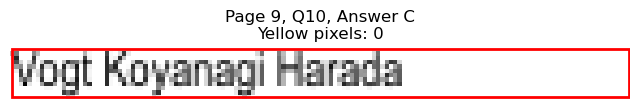

Page 9, Q10 - D: Detected box: x0=327.5, y0=709.6, x1=386.2, y1=720.7
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 325
Page 9, Q10, D: Yellow percentage: 0.0%


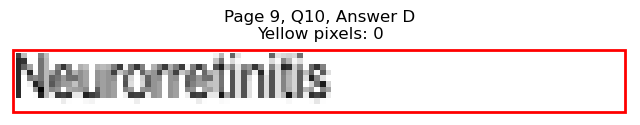


Page 9, Q10 - Selected Answer: B (based on yellow pixel count)




Page 9, Q11 - A: Detected box: x0=68.3, y0=747.4, x1=102.8, y1=758.5
Page 9, Q11, A: Yellow pixels: 0
Page 9, Q11, A: Total non-white pixels: 173
Page 9, Q11, A: Yellow percentage: 0.0%


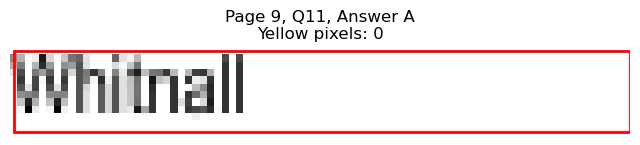

Page 9, Q11 - B: Detected box: x0=68.3, y0=760.2, x1=99.4, y1=771.2
Page 9, Q11, B: Yellow pixels: 0
Page 9, Q11, B: Total non-white pixels: 176
Page 9, Q11, B: Yellow percentage: 0.0%


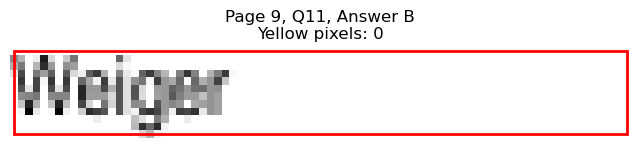

Page 9, Q11 - C: Detected box: x0=327.5, y0=747.4, x1=370.6, y1=758.5
Page 9, Q11, C: Yellow pixels: 872
Page 9, Q11, C: Total non-white pixels: 1128
Page 9, Q11, C: Yellow percentage: 77.3%


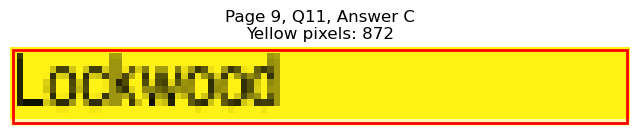

Page 9, Q11 - D: Detected box: x0=327.5, y0=760.2, x1=347.5, y1=771.2
Page 9, Q11, D: Yellow pixels: 0
Page 9, Q11, D: Total non-white pixels: 96
Page 9, Q11, D: Yellow percentage: 0.0%


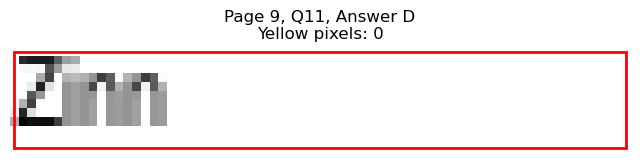


Page 9, Q11 - Selected Answer: C (based on yellow pixel count)





Page 10: Found 6 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=159.0, y1=114.8
Page 10, Q1, A: Yellow pixels: 141
Page 10, Q1, A: Total non-white pixels: 613
Page 10, Q1, A: Yellow percentage: 23.0%


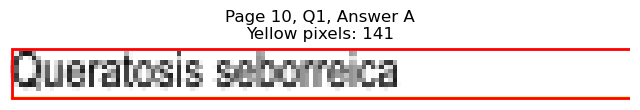

Page 10, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=148.1, y1=127.4
Page 10, Q1, B: Yellow pixels: 1129
Page 10, Q1, B: Total non-white pixels: 1572
Page 10, Q1, B: Yellow percentage: 71.8%


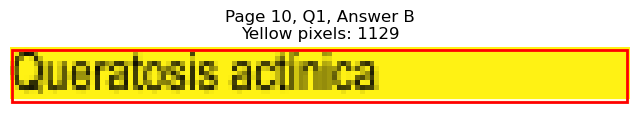

Page 10, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=388.2, y1=114.8
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 302
Page 10, Q1, C: Yellow percentage: 0.0%


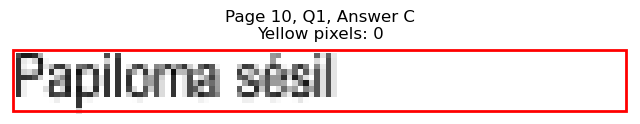

Page 10, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=387.1, y1=127.4
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 277
Page 10, Q1, D: Yellow percentage: 0.0%


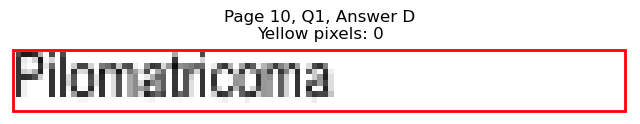


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=138.0, y1=177.9
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 341
Page 10, Q2, A: Yellow percentage: 0.0%


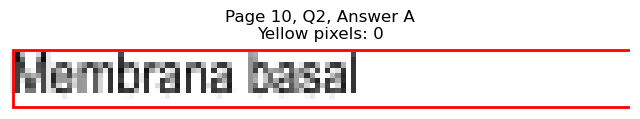

Page 10, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=169.1, y1=190.5
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 501
Page 10, Q2, B: Yellow percentage: 0.0%


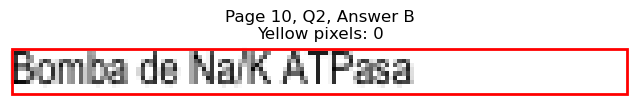

Page 10, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=385.2, y1=177.9
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 423
Page 10, Q2, C: Yellow percentage: 0.0%


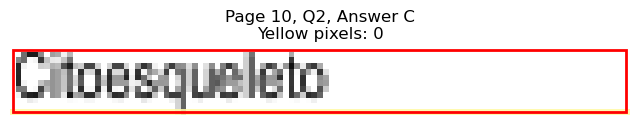

Page 10, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=403.2, y1=190.5
Page 10, Q2, D: Yellow pixels: 1112
Page 10, Q2, D: Total non-white pixels: 1524
Page 10, Q2, D: Yellow percentage: 73.0%


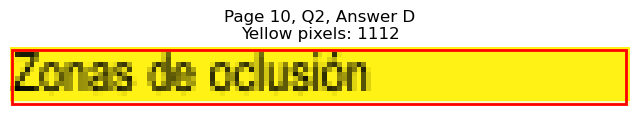


Page 10, Q2 - Selected Answer: D (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=142.0, y1=241.0
Page 10, Q3, A: Yellow pixels: 124
Page 10, Q3, A: Total non-white pixels: 621
Page 10, Q3, A: Yellow percentage: 20.0%


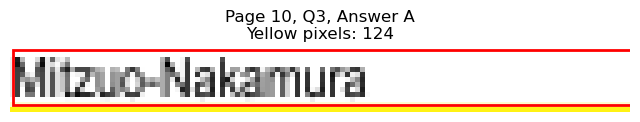

Page 10, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=140.5, y1=253.6
Page 10, Q3, B: Yellow pixels: 1063
Page 10, Q3, B: Total non-white pixels: 1476
Page 10, Q3, B: Yellow percentage: 72.0%


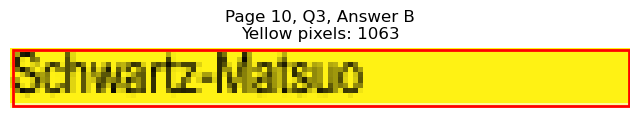

Page 10, Q3 - C: Detected box: x0=327.5, y0=230.0, x1=386.2, y1=241.0
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 299
Page 10, Q3, C: Yellow percentage: 0.0%


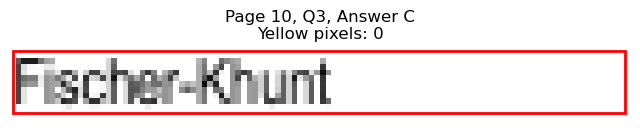

Page 10, Q3 - D: Detected box: x0=327.5, y0=242.6, x1=410.8, y1=253.6
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 429
Page 10, Q3, D: Yellow percentage: 0.0%


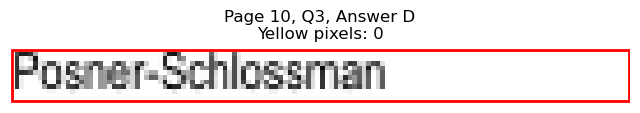


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=170.0, y1=304.2
Page 10, Q4, A: Yellow pixels: 1294
Page 10, Q4, A: Total non-white pixels: 1684
Page 10, Q4, A: Yellow percentage: 76.8%


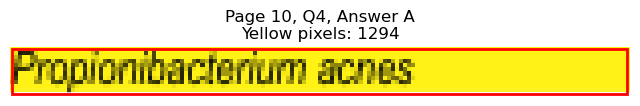

Page 10, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=175.6, y1=316.8
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 536
Page 10, Q4, B: Yellow percentage: 0.0%


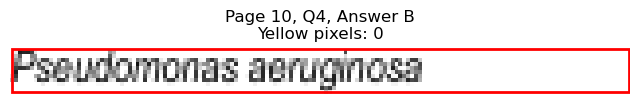

Page 10, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=421.3, y1=304.2
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 493
Page 10, Q4, C: Yellow percentage: 0.0%


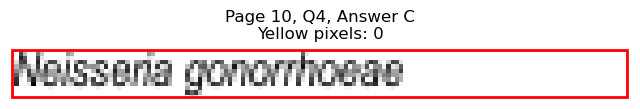

Page 10, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=426.2, y1=316.8
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 512
Page 10, Q4, D: Yellow percentage: 0.0%


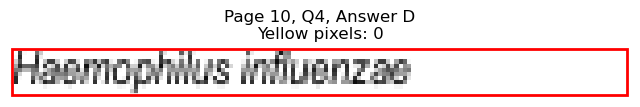


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=187.2, y1=392.5
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 637
Page 10, Q5, A: Yellow percentage: 0.0%


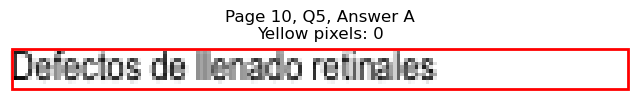

Page 10, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=136.6, y1=405.1
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 353
Page 10, Q5, B: Yellow percentage: 0.0%


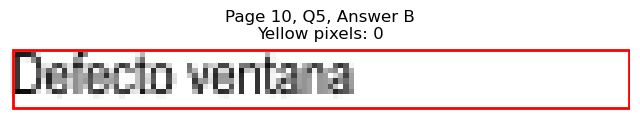

Page 10, Q5 - C: Detected box: x0=327.5, y0=381.4, x1=441.4, y1=392.5
Page 10, Q5, C: Yellow pixels: 1373
Page 10, Q5, C: Total non-white pixels: 1980
Page 10, Q5, C: Yellow percentage: 69.3%


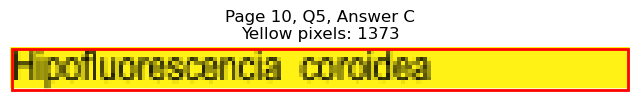

Page 10, Q5 - D: Detected box: x0=327.5, y0=394.0, x1=413.8, y1=405.1
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 453
Page 10, Q5, D: Yellow percentage: 0.0%


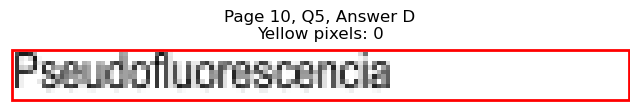


Page 10, Q5 - Selected Answer: C (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=432.0, x1=111.4, y1=443.0
Page 10, Q6, A: Yellow pixels: 950
Page 10, Q6, A: Total non-white pixels: 1128
Page 10, Q6, A: Yellow percentage: 84.2%


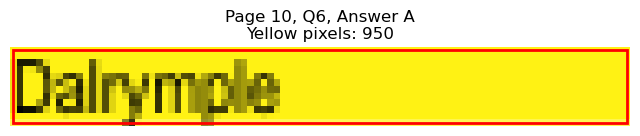

Page 10, Q6 - B: Detected box: x0=68.3, y0=444.6, x1=113.4, y1=455.6
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 258
Page 10, Q6, B: Yellow percentage: 0.0%


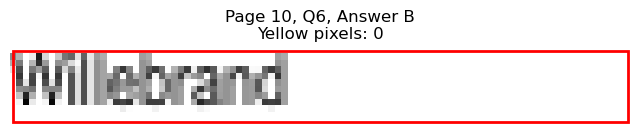

Page 10, Q6 - C: Detected box: x0=327.5, y0=432.0, x1=355.6, y1=443.0
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 151
Page 10, Q6, C: Yellow percentage: 0.0%


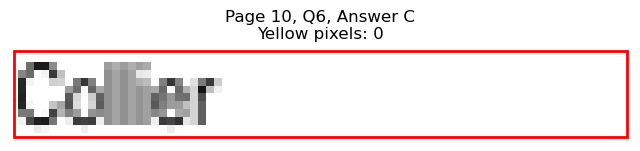

Page 10, Q6 - D: Detected box: x0=327.5, y0=444.6, x1=367.1, y1=455.6
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 210
Page 10, Q6, D: Yellow percentage: 0.0%


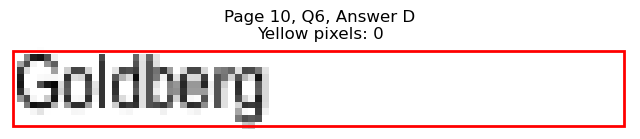


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál es una característica del albinismo ocul...
1   Adolescente de 14 años con ceguera de OD y vis...
2   ¿Cuál es la capa donde se divide la retina en ...
3   Varón de 20 años, con un diámetro anteroposter...
4   La sensación de flashes de luz producidos por ...
..                                                ...
95  ¿Qué estructura celular en común del epitelio ...
96  El desprendimiento de retina regmatógeno suele...
97  La endoftalmitis postoperatoria de comienzo ta...
98  Niña de 10 años con antecedente de hipertrofia...
99  ¿Qué signo evidencia una retracción palpebral ...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0   No pueden sintetizar melanina, tienen pelo bla...   
1                                Vogt-Koyanagi-Harada   
2                                  Plexiforme externa   
3                                 Detras de la retina   
4                                           Fotopsias   
..                                                ...   
95                                     Membrana basal   
96                                    Mitzuo-Nakamura   
97                            Propionibacterium acnes   
98                      Defectos de llenado retinales   
99                                          Dalrymple   

                                             option_B  \
0   Es la variante incompleta y la agudeza visual ...   
1                                  Oftalmía simpática   
2                                Células ganglionares   
3                                        En la retina   
4                                    Fotoestimulación   
..                                                ...   
95                               Bomba de Na/K ATPasa   
96                                    Schwartz-Matsuo   
97                             Pseudomonas aeruginosa   
98                                    Defecto ventana   
99                                         Willebrand   

                                             option_C  \
0   La hipoplasia foveal con ausencia de la depres...   
1                    Coriorretinopatía serosa central   
2                                Epitelio pigmentario   
3                       Delante y detrás de la retina   
4                                Escotoma centellante   
..                                                ...   
95                                      Citoesqueleto   
96                                      Fischer-Khunt   
97                              Neisseria gonorrhoeae   
98                        Hipofluorescencia  coroidea   
99                                            Collier   

                                             option_D  
0   El iris puede ser azul o marrón oscuro y el fo...  
1                               Enfermedad de Whipple  
2                                     Fotorreceptores  
3                                Delante de la retina  
4                                          Fotoestrés  
..                                                ...  
95                                  Zonas de oclusión  
96                                  Posner-Schlossman  
97                             Haemophilus influenzae  
98                                Pseudofluorescencia  
99                                           Goldberg  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               B
2               A
3               D
4               A
..            ...
95              D
96              B
97              A
98              C
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   ¿Cuál es una característica del albinismo ocul...   
1   Adolescente de 14 años con ceguera de OD y vis...   
2   ¿Cuál es la capa donde se divide la retina en ...   
3   Varón de 20 años, con un diámetro anteroposter...   
4   La sensación de flashes de luz producidos por ...   
..                                                ...   
95  ¿Qué estructura celular en común del epitelio ...   
96  El desprendimiento de retina regmatógeno suele...   
97  La endoftalmitis postoperatoria de comienzo ta...   
98  Niña de 10 años con antecedente de hipertrofia...   
99  ¿Qué signo evidencia una retracción palpebral ...   

                                             option_A  \
0   No pueden sintetizar melanina, tienen pelo bla...   
1                                Vogt-Koyanagi-Harada   
2                                  Plexiforme externa   
3                                 Detras de la retina   
4                                           Fotopsias   
..                                                ...   
95                                     Membrana basal   
96                                    Mitzuo-Nakamura   
97                            Propionibacterium acnes   
98                      Defectos de llenado retinales   
99                                          Dalrymple   

                                             option_B  \
0   Es la variante incompleta y la agudeza visual ...   
1                                  Oftalmía simpática   
2                                Células ganglionares   
3                                        En la retina   
4                                    Fotoestimulación   
..                                                ...   
95                               Bomba de Na/K ATPasa   
96                                    Schwartz-Matsuo   
97                             Pseudomonas aeruginosa   
98                                    Defecto ventana   
99                                         Willebrand   

                                             option_C  \
0   La hipoplasia foveal con ausencia de la depres...   
1                    Coriorretinopatía serosa central   
2                                Epitelio pigmentario   
3                       Delante y detrás de la retina   
4                                Escotoma centellante   
..                                                ...   
95                                      Citoesqueleto   
96                                      Fischer-Khunt   
97                              Neisseria gonorrhoeae   
98                        Hipofluorescencia  coroidea   
99                                            Collier   

                                             option_D correct_answer  
0   El iris puede ser azul o marrón oscuro y el fo...              A  
1                               Enfermedad de Whipple              B  
2                                     Fotorreceptores              A  
3                                Delante de la retina              D  
4                                          Fotoestrés              A  
..                                                ...            ...  
95                                  Zonas de oclusión              D  
96                                  Posner-Schlossman              B  
97                             Haemophilus influenzae              A  
98                                Pseudofluorescencia              C  
99                                           Goldberg              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/OFTALMOLOGIA.csv
